<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/videos/Practica_5_2_Regresion_lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 5.2: Modelos de regresión (univariada)

---



En este clase vamos a utilizar librerías para resolver numéricamente (utilizando cadenas de Markov e inferencia variacional) problemas de inferencia estadística. En particular, vamos a proponer modelos de probabilidad condicionada con una única variable predictora, ya sea continua o discreta.

Para ello nos montaremos sobre dos librerías (paquetes de funciones)
- [Bambi](https://bambinos.github.io/bambi/) (BAyesian Model-Building Interface): para la construcción y calibración de modelos
- [ArviZ](https://python.arviz.org/en/stable/): para la visualización de los resultados de la inferencia y la evaluación de los modelos

## Librerías

En primer lugar, importamos o instalamos todas las librerías y funciones que utilizaremos a lo largo del Colab.

In [1]:
# importar librerias utiles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# librerias para abrir archivos
import io
from google.colab import files

# instalar bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.4 MB/s eta 0:00:00


## Ejemplo 1: Resistencia del hormigón como función de la relación agua-material cementicio

En este primer ejercicio, buscaremos responder la siguiente pregunta:

**- ¿Cuál es la resistencia característica de un hormigón con relación agua-cemento (o material cementicio) de 0.4? ¿y si es 0.5?**

Para eso, vamos a usar los datos de ensayos de probetas que tenemos disponibles y ajustar un modelo.

### El dataset

Contamos con 103 muestras de hormigón ensayadas a los 28 días. Las mismas se extrajeron de un dataset público disponible en el repositorio de la Universidad de California Irvine. Pueden acceder al dataset haciendo click [aquí](https://archive.ics.uci.edu/dataset/182/concrete+slump+test).

Este dataset elaborado por I-Cheng Yeh ha sido utilizado en numerosas investigaciones.

In [2]:
# Subir archivo al colab
uploaded = files.upload()

Saving concrete_tests.csv to concrete_tests.csv


In [5]:
# Creamos el dataframe
df_horm = pd.read_csv(io.BytesIO(uploaded['concrete_tests.csv']))
df_horm

Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  SLUMP(cm)  \
0     273.0   82.0    105.0  210.0   9.0         904.0       680.0       23.0   
1     163.0  149.0    191.0  180.0  12.0         843.0       746.0        0.0   
2     162.0  148.0    191.0  179.0  16.0         840.0       743.0        1.0   
3     162.0  148.0    190.0  179.0  19.0         838.0       741.0        3.0   
4     154.0  112.0    144.0  220.0  10.0         923.0       658.0       20.0   
..      ...    ...      ...    ...   ...           ...         ...        ...   
98    248.3  101.0    239.1  168.9   7.7         954.2       640.6        0.0   
99    248.0  101.0    239.9  169.1   7.7         949.9       644.1        2.0   
100   258.8   88.0    239.6  175.3   7.6         938.9       646.0        0.0   
101   297.1   40.9    239.9  194.0   7.5         908.9       651.8       27.5   
102   348.7    0.1    223.1  208.5   9.6         786.2       758.1       29.0   

     FLOW(cm)  Compressive Strength (28-day)(Mpa)  
0        62.0                               34.99  
1        20.0                               41.14  
2        20.0                               41.81  
3        21.5                               42.08  
4        64.0                               26.82  
..        ...                                 ...  
98       20.0                               49.97  
99       20.0                               50.23  
100      20.0                               50.50  
101      67.0                               49.17  
102      78.0                               48.77  

[103 rows x 10 columns]

Lo primero que vamos a hacer es, en forma rápida, crear una nueva columna de nombre `a_c` que represente la relación agua-material cementicio, que incluye el cemento, la escoria y las cenizas volantes.

También cambiaremos el nombre de la columna de resistencia para hacerlo más amigable.

In [6]:
# Construimos una variable a/c (relacion agua cemento)
df_horm['a_c'] = df_horm['Water']/(df_horm['Cement']+df_horm['Slag']+df_horm['Fly ash'])

# cambiamos el nombre de la resistencia a la compresion
df_horm.rename(columns={'Compressive Strength (28-day)(Mpa)': 'Resistencia_MPa'}, inplace=True)

df_horm

Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  SLUMP(cm)  \
0     273.0   82.0    105.0  210.0   9.0         904.0       680.0       23.0   
1     163.0  149.0    191.0  180.0  12.0         843.0       746.0        0.0   
2     162.0  148.0    191.0  179.0  16.0         840.0       743.0        1.0   
3     162.0  148.0    190.0  179.0  19.0         838.0       741.0        3.0   
4     154.0  112.0    144.0  220.0  10.0         923.0       658.0       20.0   
..      ...    ...      ...    ...   ...           ...         ...        ...   
98    248.3  101.0    239.1  168.9   7.7         954.2       640.6        0.0   
99    248.0  101.0    239.9  169.1   7.7         949.9       644.1        2.0   
100   258.8   88.0    239.6  175.3   7.6         938.9       646.0        0.0   
101   297.1   40.9    239.9  194.0   7.5         908.9       651.8       27.5   
102   348.7    0.1    223.1  208.5   9.6         786.2       758.1       29.0   

     FLOW(cm)  Resistencia_MPa       a_c  
0        62.0            34.99  0.456522  
1        20.0            41.14  0.357853  
2        20.0            41.81  0.357285  
3        21.5            42.08  0.358000  
4        64.0            26.82  0.536585  
..        ...              ...       ...  
98       20.0            49.97  0.287050  
99       20.0            50.23  0.287146  
100      20.0            50.50  0.298943  
101      67.0            49.17  0.335698  
102      78.0            48.77  0.364574  

[103 rows x 11 columns]

Ya que queremos predecir la resistencia del hormigón para una determinada relación agua-cemento, veamos cómo interactuan estas dos variables entre sí en el dataset.

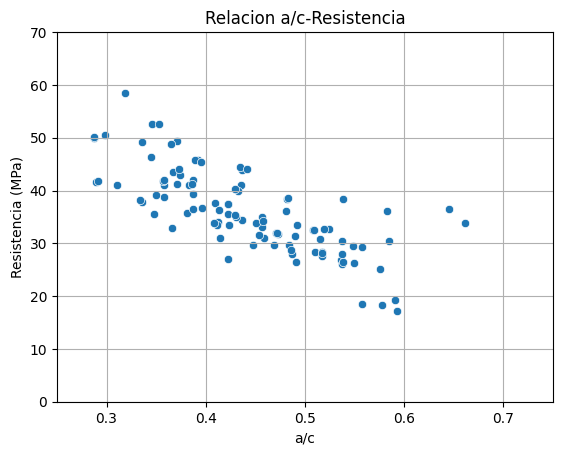

In [7]:
# graficamos la relacion a/c-Resistencia
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa')
plt.grid(True)
plt.xlabel('a/c')
plt.ylabel('Resistencia (MPa)')
plt.title('Relacion a/c-Resistencia')
plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

Viendo el gráfico podrán notar dos cosas. Por un lado, no hay un sólo dato que tenga las relaciones agua-cemento que me interesan predecir. "No tengo los datos" para hacer un modelo de inferencia como veníamos trabajando hasta ahora (más allá de asumir que la `a/c` no importa y agrupar todo). Sin embargo, parece haber claramente una relación entre `a/c` y la resistencia ensayada de las probetas.

Por lo tanto, si pudiesemenos ajustar un modelo que determine cómo es esa relación entre `a/c` y la resistencia, podríamos luego usarlo para predecir datos nunca vistos como los pedidos al principio del problema.

### Modelo 1: Recta + error

El modelo más sencillo que podríamos plantear es una recta. Más formalmente, un modelo donde el valor medio es explicado por una recta a la que se le suma un término de error aleatorio.

$$y = A + B\cdot a/c + error$$

$$error \sim Normal(0,\sigma)$$

Otra forma de plantear esto mismo más genérica es como un modelo de probabilidad condicional. Es decir, la resistencia de la probeta dada la relación agua-cemento sigue una distribución normal cuyo valor medio depende de esta relación agua-cemento (en forma lineal).

$$Y \sim Normal(\mu,\sigma)$$

$$\mu = A + B \cdot a/c$$

Para nuestro proceso de inferencia, donde aplicaremos el teorema de bayes para definir la densidad de probabilidad posterior de los parámetros $A$, $B$, $\sigma$, necesitamos primer definir distribuciones a priori. Es decir, la probabilidad de que los parámetros tomen determinados valores *antes* de ver los datos.

Nosotros vamos a dejar que `Bambi` adopte distribuciones poco informativas por nosotros:

$$p(A) \sim Bambi$$
$$p(B) \sim Bambi$$
$$p(\sigma) \sim Bambi$$

#### Modelo

Cargar este modelo en `Bambi` es bastante sencillo, ya que el modelo normal (`family='gaussian'`) es el default del programa, y la ecuación para el valor medio (`link='identity'`) es el default para el modelo normal.

Por lo tanto, simplemente hay que indicar la columna del dataset que se quiere predecir (`Resistencia_MPa`) y las variables explicativas (`a_c`). `Bambi` automáticamente hace lo siguiente:

- Agrega una ordenada al origen o "Intercept" (lo que habíamos llamado $A$)
- Multiplica a la variable predictora por una constante con el mismo nombre. Es decir, llama $a\_c$ al parámetro que multiplica al predictor `a_c` del dataset (lo que habíamos llamado $B$)
- Genera el parámetro del desvío de la normal "sigma" ($\sigma$).

ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: random_make_inplace
ERROR:pytensor.graph.rewriting.basic:node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/random/rewriting/basic.py", line 50, in random_make_inplace
    new_outputs = new_op.make_node(*node.inputs).outputs
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^

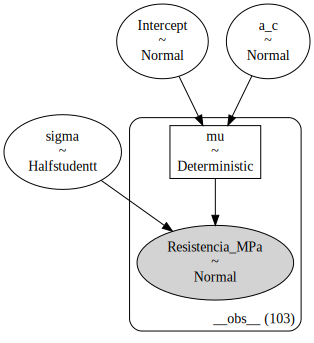

In [8]:
# creamos un modelo lineal (con error absoluto)
model_1 = bmb.Model('Resistencia_MPa ~ a_c', data=df_horm)
model_1.build()

# visualizacion
model_1.graph()

#### Prioris

Si bien arriba se puede ver en forma esquemática cómo funciona el modelo y las distribuciones a priori adotptadas, siempre es bueno visualizarlas para ver si están transmitiendo la información previa que nosotros queremos (o la no-información)

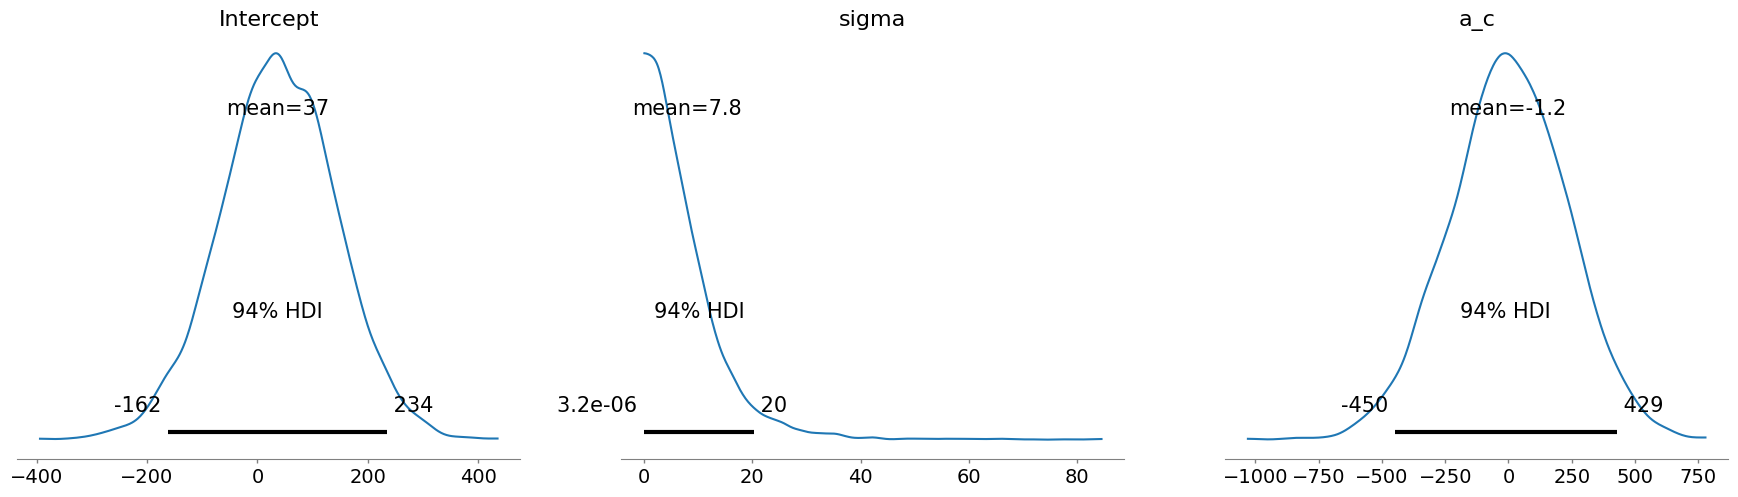

In [9]:
# ver distribuciones a priori
model_1.plot_priors()
plt.show()

#### Inferencia

Si ya tenemos nuestro modelo construido de acuerdo a nuestras necesidades, procedemos a hacer la inferencia. En este paso generaremos simulaciones de la distribución posterior de los parámetros ($Intercept$, $a\_c$, $sigma$) mediante cadenas de Markov. Estas se guardaran en mi variable `results_1`

Para asegurarnos que esté todo ok, revisamos que no haya divergencias durante el proceso, y que las cadenas hayan convergado tanto internamente como entre sí, pareciéndose a un ruido blanco.

Output()

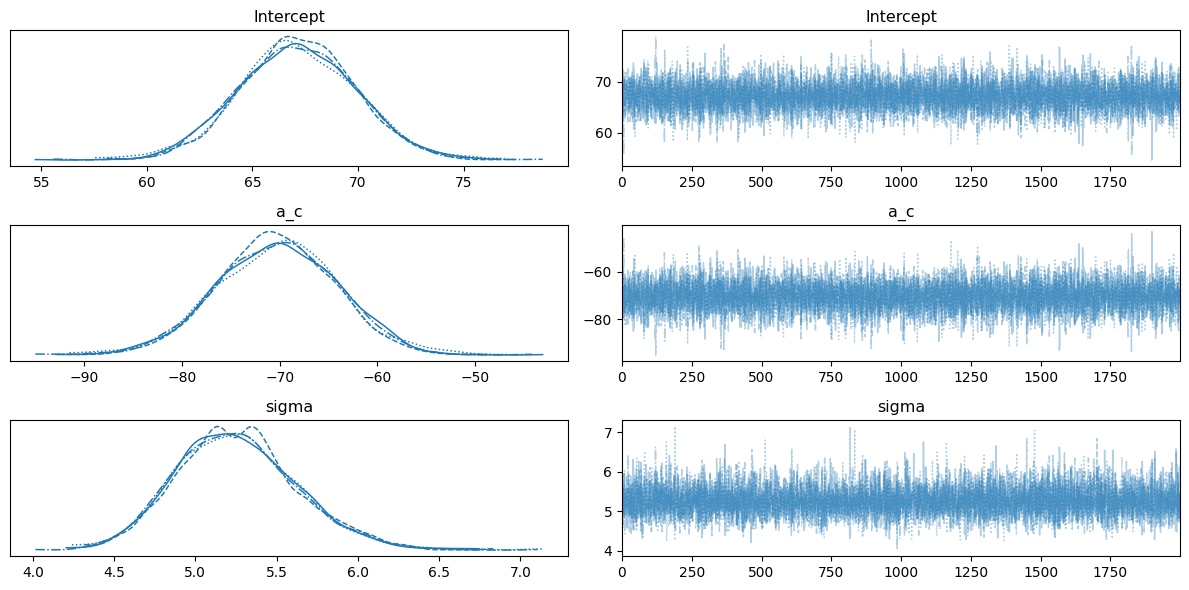

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  67.143  2.769  61.686   72.009      0.027    0.032   10741.0   
a_c       -70.322  6.157 -81.727  -58.691      0.059    0.072   10889.0   
sigma       5.256  0.374   4.598    5.995      0.004    0.005   10933.0   

           ess_tail  r_hat  
Intercept    5961.0    1.0  
a_c          5910.0    1.0  
sigma        6103.0    1.0

In [10]:
# Realizar la inferencia
results_1 = model_1.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_1)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_1)

¡En este caso todo parece andar bien!

#### Posterior

Si nuestra inferencia salió bien, ya podemos empezar a ver qué me dice. Por ejemplo, lo primero que puedo ver es cuánto valen los parámetros de mi modelo. Es decir, su distribución posterior (dado que tengo estos datos, ¿cuál es la probabilidad de que los parámetros valgan determinado valor?).

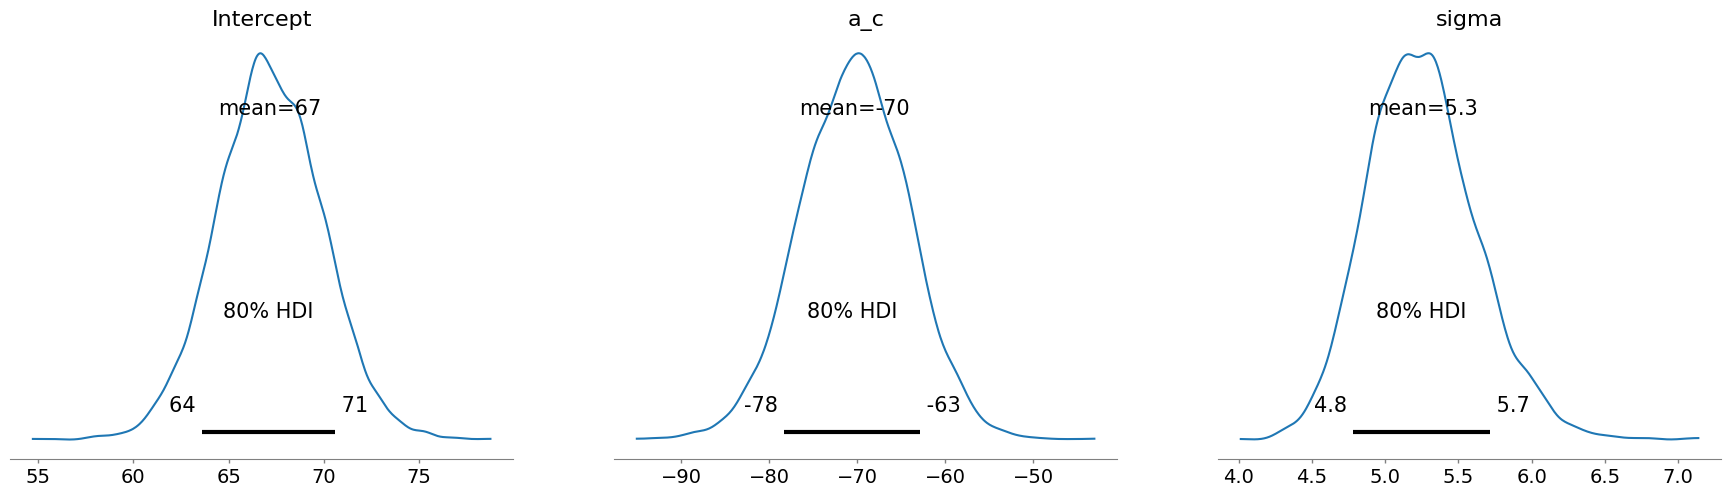

In [11]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_1,hdi_prob=0.8)
plt.show()

Es posible acceder manualmente a las simulaciones si así se requiere dentro de mi Inference Data (`results_1`). Fijensé que es clickeable, y pueden explorar todo lo que tiene. En particular, pueden acceder a las simulaciones de los parámetros.

In [12]:
results_1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Por ejemplo, puedo extraer la matriz con las simulaciones de la pendiente de la recta $a\_c$ de la siguiente forma:

**Nota:** Las dimensiones son (4,2000): 4 cadenas, 2000 simulaciones por cadena.

In [13]:
results_1.posterior['a_c'].values

array([[-72.28092141, -86.09639971, -74.81073205, ..., -69.01543627,
        -65.06517   , -70.66190461],
       [-69.97874708, -66.89628634, -75.52227546, ..., -67.31011416,
        -72.63847148, -72.63847148],
       [-72.57265716, -70.85125932, -72.23983615, ..., -69.20548408,
        -70.56174078, -70.56174078],
       [-66.22655825, -64.13751339, -75.89962266, ..., -79.92841969,
        -70.16145574, -68.51115038]])

#### Visualización del ajuste

Si bien lo anterior me dice cuánto valen los parámetros, no me permite ver rápidamente cómo funciona mi modelo y qué predice. Y si no me dice qué predice, dificilmente pueda sacar conclusiones reales ni verificar si se ajusta bien a los datos disponibles.

Para hacer eso podemos usar la función de `bambi` "[interpret.plot_predictions()](https://bambinos.github.io/bambi/api/interpret.plot_predictions.html)". En esta se introduce:

- El modelo
- El Inference Data con las simulaciones de los parámetros
- Qué variables predictoras considerar en el eje $X$ y (opcional) en qué valores evaluarlas
- Si se quiere graficar el valor medio (`pps=False`) o valores puntuales de la variable a predecir (`pps=True`)
- El intervalo de confianza a graficar

A medida que sea necesario, iremos introduciendo más opciones disponibles en esta función.

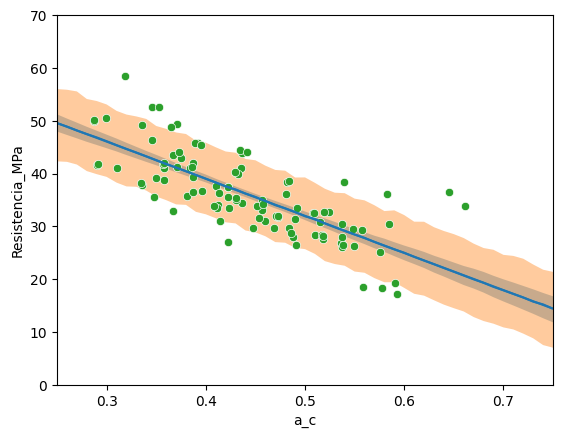

In [14]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_1,results_1,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_1,results_1,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

Vean que ahora se ve mucho más claro qué me dice el modelo. Por ejemplo, se ve visualmente cuánto cae la resistencia a medida que aumenta la proporción de agua en la mezcla. También se puede ver la incertidumbre en el valor medio (sombra azul), y la dispersión de resultados de una muestra en particular (sombra naranja).

Efectivamente no hice más que ajustar una recta, pero incluyendo incertidumbres.

Luego, podremos discutir si el ajuste es bueno o no (por ejemplo, pareciera que subestimo los datos de las puntas y tiendo a sobreestimar en valores "medios" de agua-cemento.

### Modelo 2: Hipérbola + error

Este proceso que aplicamos recién podemos usarlo para prácticamente cualquier otro modelo de inferencia. De aquí en más vamos a ir planteando otros modelos simplemente para mostrar distintas variantes que pueden aparecer a la hora de definir el modelo. ¡Todo lo demás es igual!

Uno podía ver los datos de arriba y pensar que la mejor forma de ajustar los datos es con una hipérbola:

$$y = \frac{1}{A\cdot a/c} + error$$

$$error \sim Normal(0,\sigma)$$

Escrito en el formato que venimos manejando a lo largo de la materia, esto sería:

$$Y \sim Normal(\mu,\sigma)$$

$$\frac{1}{\mu} = A\cdot a/c$$

**Noten que la ecuación está definida para la inversa del valor medio, y que no tiene ordenada al origen**. Luego, definimos distribuciones a priori para los parámetros $A$ y $\sigma$

$$p(A) \sim Exponential(1)$$
$$p(\sigma) \sim Exponential(1)$$

Para cargarlo en `Bambi` debo tener únicamente el cuidado de aclarar el `link='inverse', ya que la ecuación se definió para la inversa del valor medio. Por otro lado, para decir no hay ordenada al origen (no hay "Intercept") lo dejo explicitado con un $0$ en la ecuación

**Nota**: En este caso se definieron a mano las distribuciones a priori porque el link utilizado no es el default para la distribución normal.

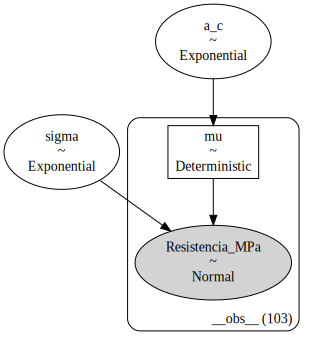

In [15]:
# creamos un modelo hiperbólico (con error absoluto)
prioris = {'a_c':bmb.Prior('Exponential',lam=1),'sigma':bmb.Prior('Exponential',lam=1)}

model_2 = bmb.Model('Resistencia_MPa ~ 0 + a_c', data=df_horm,link='inverse',priors=prioris)
model_2.build()

# visualizacion
model_2.graph()

Puedo ver las prioris que adopté:

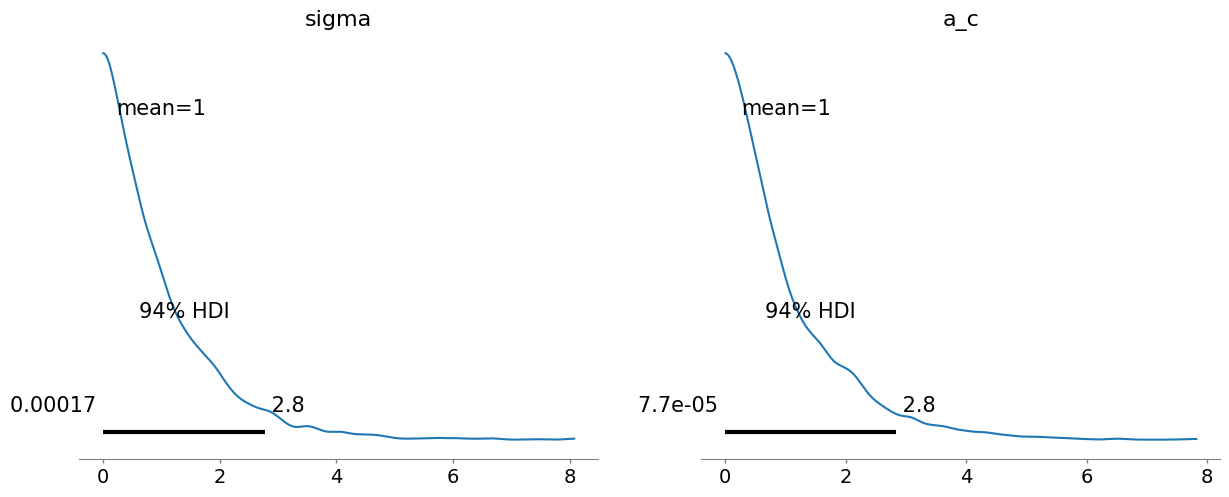

In [16]:
# ver distribuciones a priori
model_2.plot_priors()
plt.show()

Hacer la inferencia y chequear la convergencia de las cadenas:

Output()

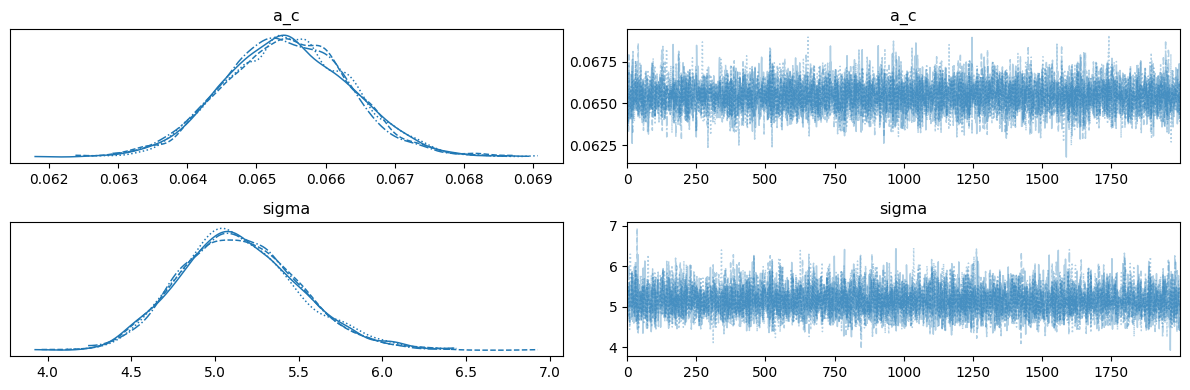

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a_c    0.065  0.001   0.064    0.067      0.000    0.000    7728.0    5341.0   
sigma  5.147  0.352   4.476    5.783      0.004    0.004    7997.0    5703.0   

       r_hat  
a_c      1.0  
sigma    1.0

In [17]:
# Realizar la inferencia
results_2 = model_2.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_2)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_2)

Ver la distribución posterior de los parámetros:

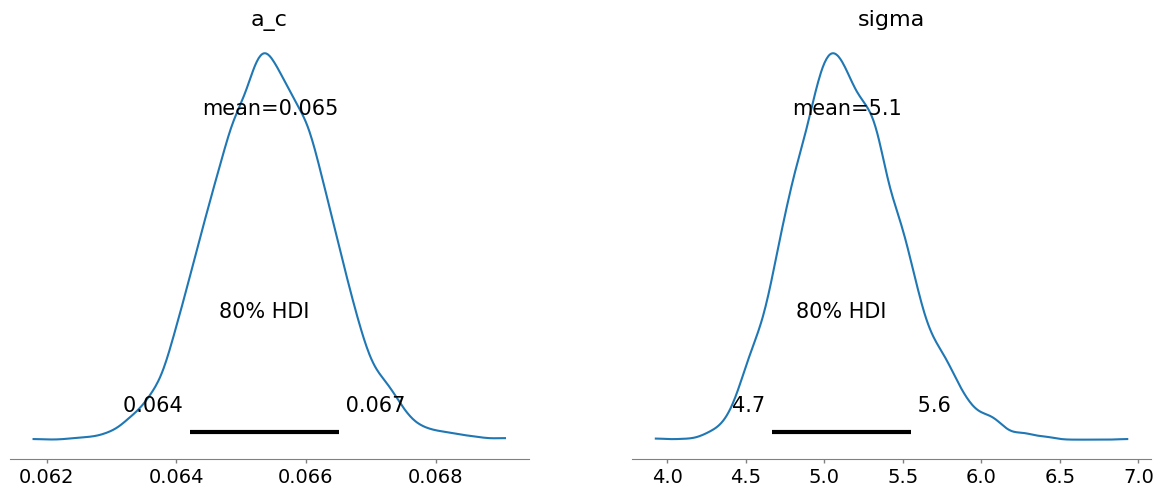

In [18]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_2,hdi_prob=0.8)
plt.show()

Y visualizar el ajuste de la hipérbola con los intervalos de confianza. ¡Todo es exactamente igual que antes!

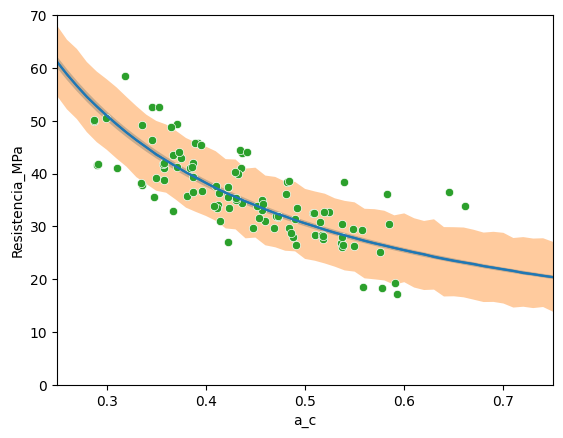

In [19]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_2,results_2,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_2,results_2,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

### Modelo 3: Parábola + error

También podríamos probar de ajustar una parábola a los datos:

$$y = A + B\cdot a/c + C\cdot {a/c}^{2} + error$$

$$error \sim Normal(0,\sigma)$$

Escrito en el formato que venimos manejando a lo largo de la materia, esto sería:

$$Y \sim Normal(\mu,\sigma)$$

$$\mu = A + B\cdot a/c + C\cdot {a/c}^{2}$$

Con las distribuciones a priori de los parámetros definidas automáticamente por `Bambi`:

$$p(A) \sim Bambi$$
$$p(B) \sim Bambi$$
$$p(C) \sim Bambi$$
$$p(\sigma) \sim Bambi$$

Para cargarlo en `Bambi`, lo más importante es saber que si algo se escribe entre llaves `{ }`, entonces eso lo considera una "cuenta matemática determinística". Por ejemplo, si quiero que algo depende de $X^{2}$, siendo $X$ una columna de mi dataframe, escribiría `{X**2}`. Con esto, `Bambi` sabe automáticamente que debe tomar la variable `X` y llevarlo al cuadrado.

Esto es mucho mejor que crear una columna en mi dataset con $X^{2}$ porque a fin de cuentas mi predictor es $X$, el cuadrado simplemente indica cómo mi problema se relaciona con $X$. No son dos predictores distintos.

ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: random_make_inplace
ERROR:pytensor.graph.rewriting.basic:node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/random/rewriting/basic.py", line 50, in random_make_inplace
    new_outputs = new_op.make_node(*node.inputs).outputs
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^

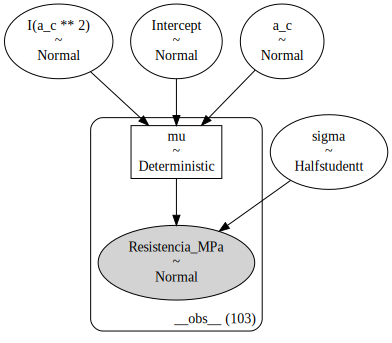

In [20]:
# creamos un modelo parabolico (con error absoluto)
model_3 = bmb.Model('Resistencia_MPa ~ a_c + {a_c**2}', data=df_horm)
model_3.build()

# visualizacion
model_3.graph()

Después, todo lo demás sigue igual...

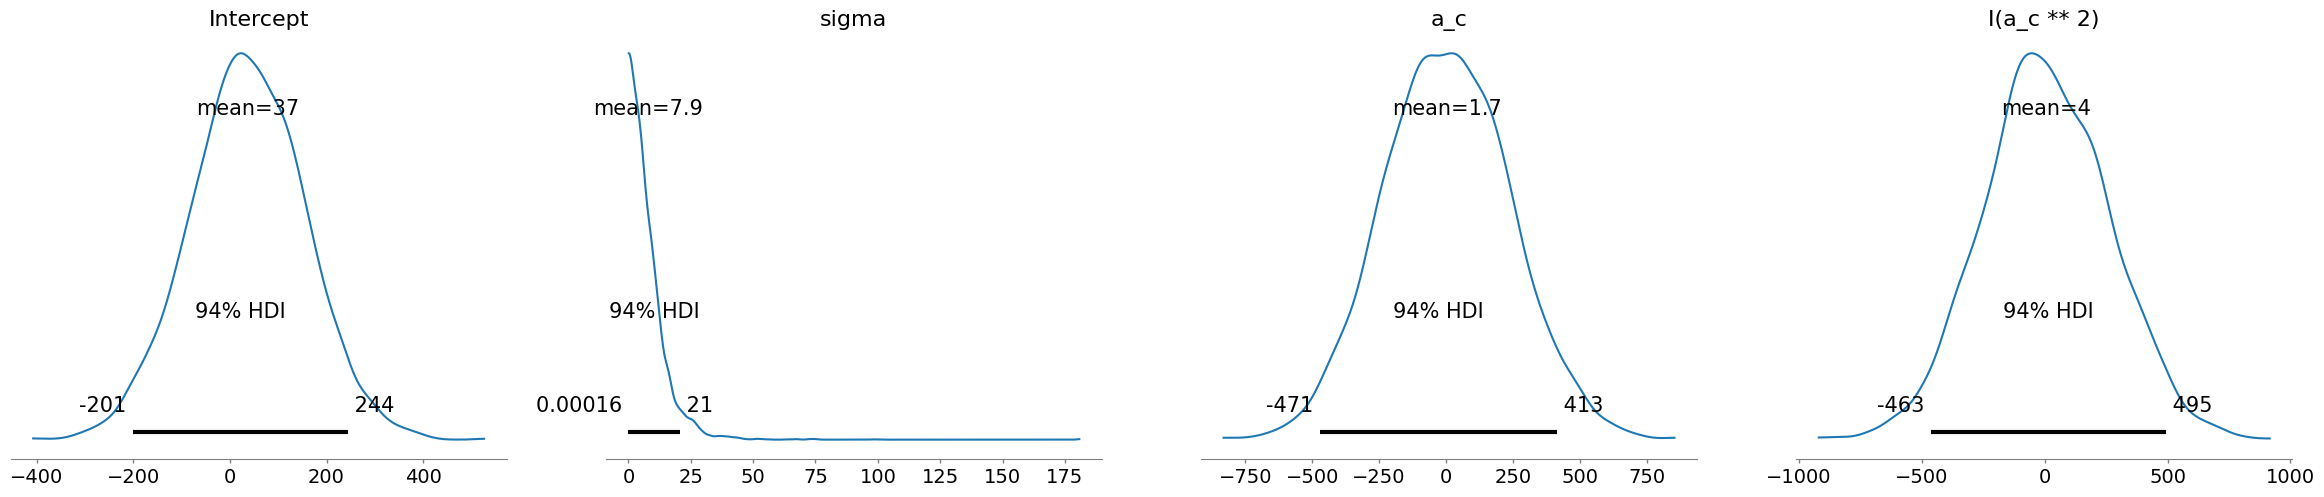

In [21]:
# ver distribuciones a priori
model_3.plot_priors()
plt.show()

Output()

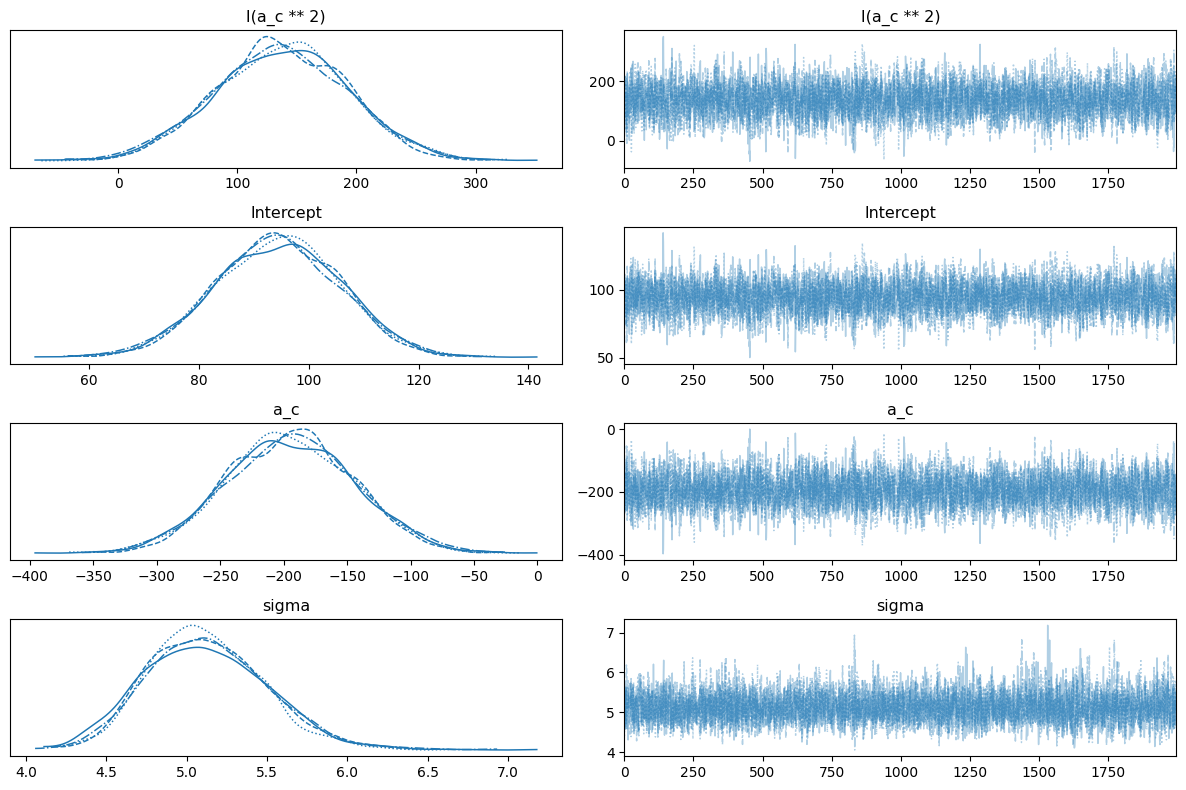

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
I(a_c ** 2)  137.372  56.060   26.722  236.505      0.895    0.698    3920.0   
Intercept     94.315  11.392   71.778  114.462      0.182    0.142    3943.0   
a_c         -194.627  51.067 -285.601  -94.572      0.819    0.642    3891.0   
sigma          5.127   0.374    4.441    5.817      0.005    0.006    4923.0   

             ess_tail  r_hat  
I(a_c ** 2)    4301.0    1.0  
Intercept      4202.0    1.0  
a_c            4309.0    1.0  
sigma          3650.0    1.0

In [22]:
# Realizar la inferencia
results_3 = model_3.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_3)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_3)

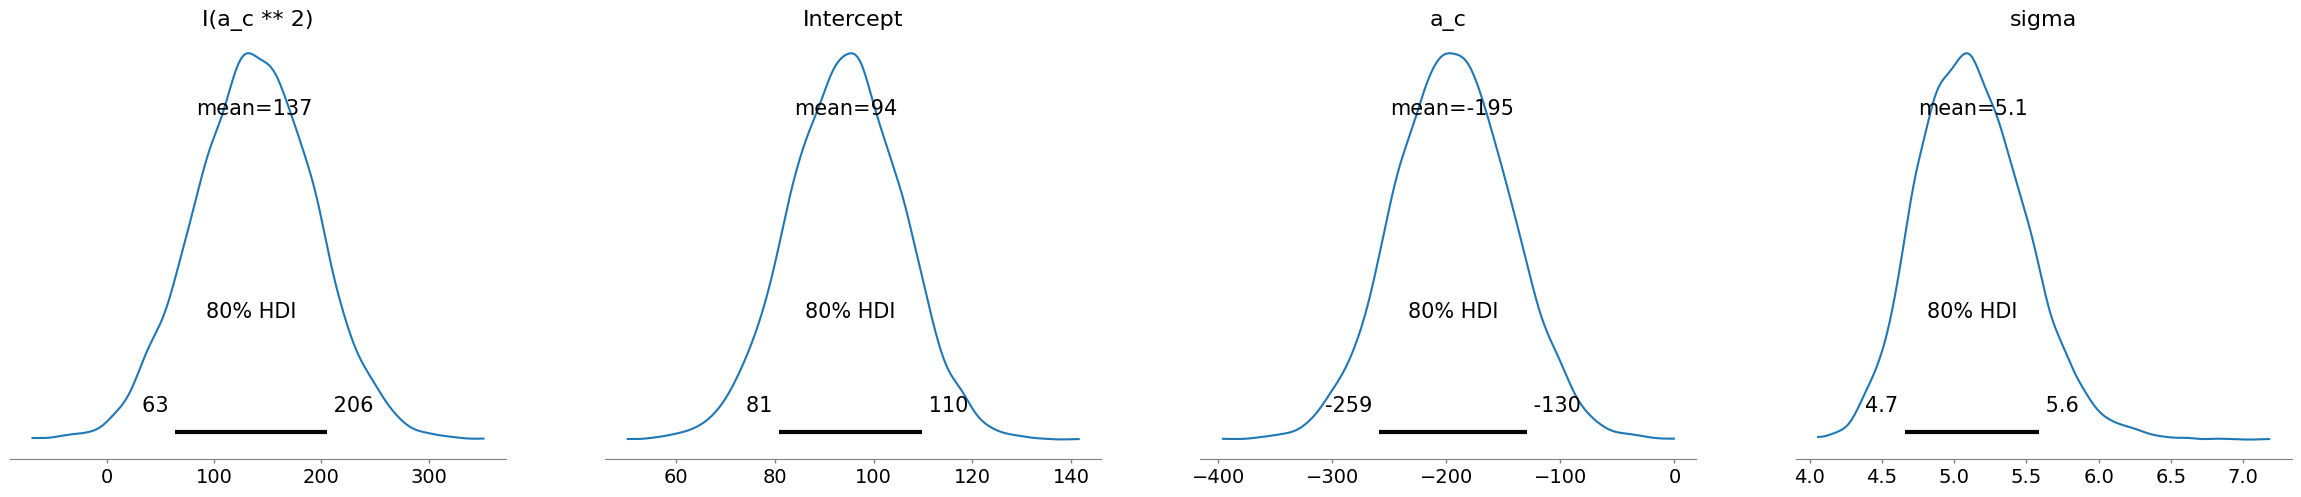

In [23]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_3,hdi_prob=0.8)
plt.show()

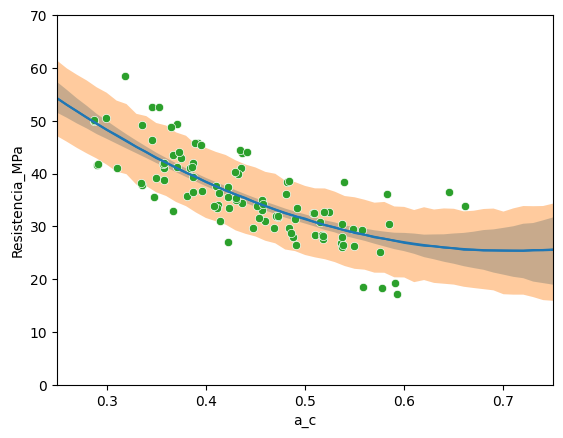

In [24]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_3,results_3,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_3,results_3,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

### Análisis de nuevos datos

Con lo que vimos hasta ahora ya sabemos construir y ajustar un modelo, y "ver qué da". Pero con eso no me alcanza para contestar la pregunta original:

**- ¿Cuál es la resistencia característica de un hormigón con relación agua-cemento (o material cementicio) de 0.4? ¿y si es 0.5?**

Para esto vamos a tener que generar simulaciones específicas para estos hormigones que nunca vi originalmente. En esta sección vamos a ver cómo simular datos que no vi.

#### Nuevo DataFrame

Así como para ajustar datos, a los datos vistos los ponemos dentro de un DataFrame, lo mismo haremos para los datos no vistos.

Yo quiero predecir la resistencia de hormigones con `a_c` de 0.4 y 0.5, así que me armo un DataFrame con estos nuevos datos de entrada (no tienen dato de salida porque nunca los ensayé).

In [25]:
# Analizar un hormigon con a/c = 0.4 y con a/c = 0.5
df_new = pd.DataFrame({'a_c':[0.4,0.5]})
df_new

a_c
0  0.4
1  0.5

#### Predcción con el Modelo 1

Para predecir resistencias de estos nuevos datos, usamos la función `.predict()` de `Bambi`. Vamos a necesitar el Inference Data con las simulaciones de los parámetros del modelo, el nuevo dataframe y aclarar que queremos simulaciones de la respuesta y no sólo el valor medio (`kind = 'response'`).

Para no sobrescribir información, vamos a guardar un nuevo Inference Data aparte con otro nombre. Para eso, aclaramos `inplace=False`).

In [26]:
# Generar simulaciones de las nuevas mezclas
results_1_new = model_1.predict(results_1,data=df_new,inplace=False,kind='response')

results_1_new

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Verán que dentro de `Posterior` ahora aparece, además de los parámetros del modelo, el cálculo de valor medio `mu` mediante simulación para cada dato a predecir, ahorrandome trabajo. Luego, en lo que se llama `Posterior_Predictive` tienen las simulaciones de las resistencias en sí para cada dato.

A ambas simulaciones puedo acceder en forma similar.

In [27]:
results_1_new.posterior_predictive['Resistencia_MPa'].values

array([[[35.32627077, 40.2050397 ],
        [32.7644668 , 21.0263461 ],
        [37.87851628, 30.31795654],
        ...,
        [50.7621541 , 21.74800666],
        [40.22377764, 29.12978269],
        [35.99579624, 24.87928698]],

       [[43.78263252, 31.56884015],
        [40.09270471, 34.38634806],
        [45.01382106, 35.91202143],
        ...,
        [34.32213567, 39.61353145],
        [42.57581412, 36.65264794],
        [35.36503693, 28.43676926]],

       [[45.63125685, 35.06543761],
        [35.6393625 , 24.87578647],
        [45.65699847, 26.27086941],
        ...,
        [38.30352579, 37.94322525],
        [42.92007166, 32.68057956],
        [45.60199579, 34.89529222]],

       [[44.70851787, 26.40725148],
        [42.22719432, 27.87105227],
        [38.36903742, 35.50031887],
        ...,
        [42.12175005, 28.1304655 ],
        [40.9403659 , 27.96480366],
        [36.67752909, 26.66273631]]])

Más allá de eso, puedo visualizar las predicciones rápidamente con `plot_posterior()`de ArviZ. Por ejemplo, las propiedades (valor medio, desvío) de los nuevos datos.

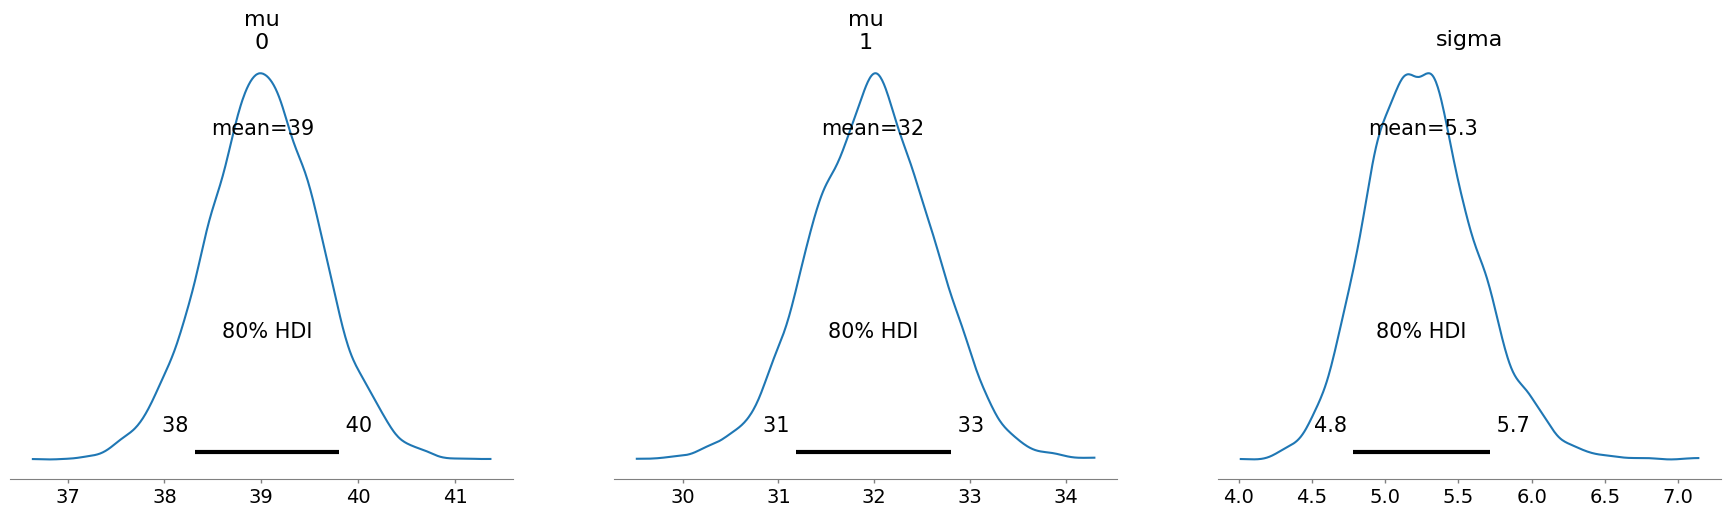

In [28]:
# Ver el valor medio y desvío de las nuevas muestras
az.plot_posterior(results_1_new,var_names=['mu','sigma'],hdi_prob=0.8)
plt.show()

Y lo mismo para distribución de resistencias para cada dato (relación agua-cemento). `0` se refiere al primer dato ($a/c=0.4$) y `1` al segundo ($a/c=0.5$).

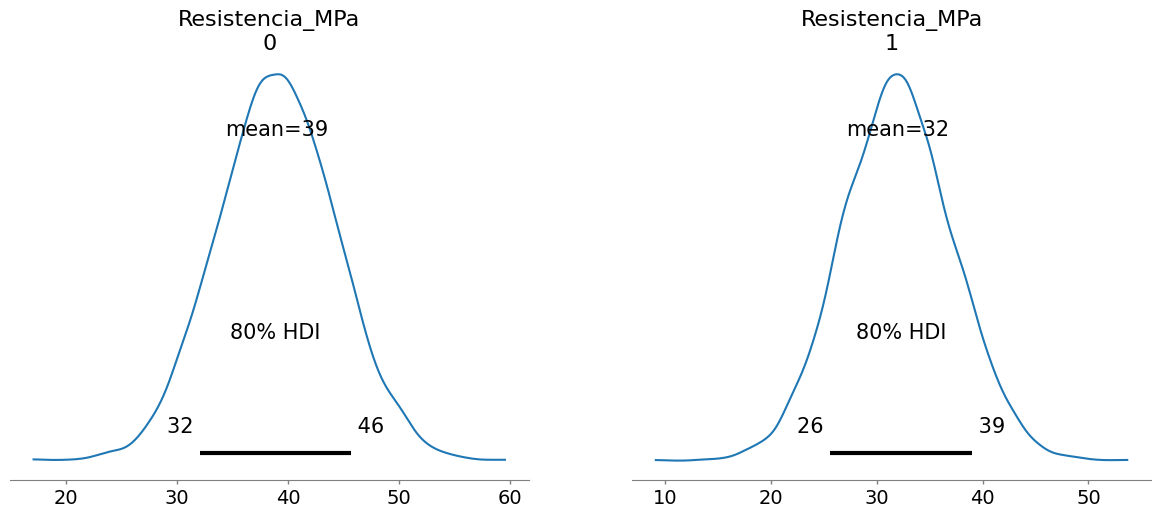

In [29]:
# grafico
az.plot_posterior(results_1_new,group='posterior_predictive',hdi_prob=0.8)
plt.show()

Luego, accediendo manualmente a las simulaciones puedo calcular la resistencia característica (el percentil 10) y contestar la pregunta original del ejercicio (o lo que necesite hacer, tengo las simulaciones a mano).

In [30]:
# ver el resultado de las simulaciones
Sims_1 = results_1_new.posterior_predictive['Resistencia_MPa'].values

# Resistencia Caracteristica
fc_1_0 = np.quantile(Sims_1[:,:,0],0.1)
fc_1_1 = np.quantile(Sims_1[:,:,1],0.1)

print('Resistencia caracteristica para a/c=0.4:',np.round(fc_1_0,2),'MPa')
print('Resistencia caracteristica para a/c=0.5:',np.round(fc_1_1,2),'MPa')

Resistencia caracteristica para a/c=0.4: 32.15 MPa
Resistencia caracteristica para a/c=0.5: 25.33 MPa


## Ejemplo 2: Comparación de la tensión entre cables

En este segundo ejercicio la pregunta es más directa: simplemente queremos conocer la tensión en dos cables en base a la estimación realizada por el método de la cuerda vibrante.

El ejemplo servirá de excusa para ver más sobre el uso de variables discretas (el número de cable en este caso) como predictores.

### El dataset

En el año 2019 se realizaron ensayos en el Puente de la Mujer, Buenos Aires, para determinar las tensiones en los cables que lo decoran. Para ello, se generaba una acción impulsiva en los mismos con un martillo, registrándose las aceleraciones resultantes (el ensayo fue repetido con el puente en su configuración abierta y cerrada al paso de embarcaciones). Luego, a partir de la Transformada de Fourier y un algoritmo desarrollado específicamente para tal fin, se encontraron las frecuencias naturales $f_{n}$ y el número de modo asociado $n$.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1DD-Fy7vanfjr94VCq0zCaBI0JYlDUJMK'; width= 50%;
  height= auto />
<figcaption>Registro de aceleraciones del Cable 14 con puente en configuración cerrada</figcaption></center>
</figure>

El dataset presente a continuación tiene para todos los cables de puente y para ambas configuraciones de servicio, todos los valores de $n$ y $f_{n}$ encontrados a partir de los ensayos.

In [31]:
# Subir archivo al colab
uploaded = files.upload()

Saving Cables.csv to Cables.csv


In [32]:
# Creamos el dataframe
df_cable = pd.read_csv(io.BytesIO(uploaded['Cables.csv']))
df_cable

fn_Hz   n  N_Cable Puente  long_m  masa_p_long_kg_m
0     5.027848   1        1      C   9.821               3.6
1    10.131991   2        1      C   9.821               3.6
2    15.548943   3        1      C   9.821               3.6
3    21.377890   4        1      C   9.821               3.6
4    27.748531   5        1      C   9.821               3.6
..         ...  ..      ...    ...     ...               ...
761  48.432136  21       18      A  43.383               3.6
762  50.881209  22       18      A  43.383               3.6
763  53.345541  23       18      A  43.383               3.6
764  55.840391  24       18      A  43.383               3.6
765  58.350500  25       18      A  43.383               3.6

[766 rows x 6 columns]

Como puede ver, el dataset tiene los siguientes datos:
- $n$ : n
- $L$ : long_m
- $\mu$ : masa_p_long_kg_m
- $f_{n}$ : fn_Hz
- Nro. de Cable: N_Cable (del 1 al 18)
- Condición del Puente: C (Cerrado), A (Abierto)

Sabemos a su vez (aunque no está en el dataset), que todos los cables tienen el mismo diámetro.

De la teoría de cables, sabemos que, si ignoramos la rigidez a flexión, la tensión en un cable se puede calcular como:

$$T = 4 \mu \left(\frac{L\cdot f}{n} \right)^{2} + error$$

Vamos a construir, entonces, una columna en el dataset que incluya esta estimación del período en función de la frecuencia y número de modo medido.

In [33]:
# Calculamos la tension de cada dato en kN
df_cable['T_kN'] = 4/1000*(df_cable['long_m']*df_cable['fn_Hz']/df_cable['n'])**2*df_cable['masa_p_long_kg_m']

df_cable

fn_Hz   n  N_Cable Puente  long_m  masa_p_long_kg_m        T_kN
0     5.027848   1        1      C   9.821               3.6   35.110591
1    10.131991   2        1      C   9.821               3.6   35.645398
2    15.548943   3        1      C   9.821               3.6   37.310680
3    21.377890   4        1      C   9.821               3.6   39.671954
4    27.748531   5        1      C   9.821               3.6   42.777353
..         ...  ..      ...    ...     ...               ...         ...
761  48.432136  21       18      A  43.383               3.6  144.155196
762  50.881209  22       18      A  43.383               3.6  144.967660
763  53.345541  23       18      A  43.383               3.6  145.794863
764  55.840391  24       18      A  43.383               3.6  146.715523
765  58.350500  25       18      A  43.383               3.6  147.642298

[766 rows x 7 columns]

Para un correcto análisis del dataset, vamos a concentrarnos únicamente en los cables 16 y 14, y convertiremos a la variable `N_Cable`en una categórica en vez de numérica.

In [34]:
# Me concentro en los cables 10 y 14
df_c_red = df_cable.copy()[(df_cable['N_Cable']==10) | (df_cable['N_Cable']==14)]

# cambio el numero de cable a una categoria
df_c_red['N_Cable'] = df_c_red['N_Cable'].astype('category')

df_c_red.dtypes

fn_Hz                float64
n                      int64
N_Cable             category
Puente                object
long_m               float64
masa_p_long_kg_m     float64
T_kN                 float64
dtype: object

In [35]:
df_c_red

fn_Hz   n N_Cable Puente  long_m  masa_p_long_kg_m        T_kN
164   2.319371   1      10      C  27.133               3.6   57.029385
165   4.608225   2      10      C  27.133               3.6   56.281467
166   6.912337   3      10      C  27.133               3.6   56.281467
167   9.239338   4      10      C  27.133               3.6   56.561358
168  11.581598   5      10      C  27.133               3.6   56.879407
..         ...  ..     ...    ...     ...               ...         ...
671  45.563439  17      14      A  35.235               3.6  128.424002
672  48.416876  18      14      A  35.235               3.6  129.347956
673  51.308461  19      14      A  35.235               3.6  130.371247
674  54.230564  20      14      A  35.235               3.6  131.443554
675  57.190814  21      14      A  35.235               3.6  132.594348

[100 rows x 7 columns]

A continuación pueden ver los hisogramas (o densidades empíricas) para los períodos estimados, separando por número de cable. Pareciera que son distintos. Es decir, que el número de cable es un buen predictor de la tensión.

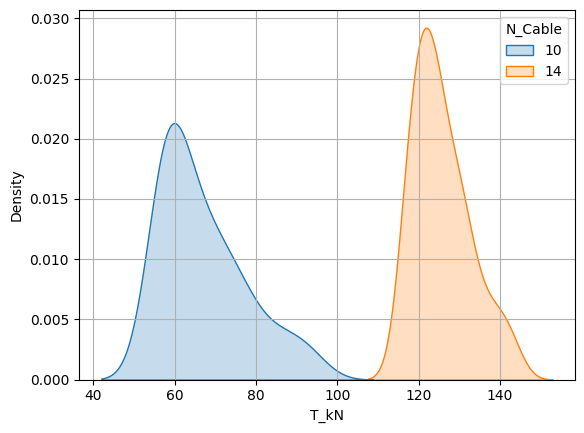

In [36]:
# Grafico
sns.kdeplot(data=df_c_red,x='T_kN',hue='N_Cable',fill=True)
plt.grid(True)
plt.show()

### Modelo 1: Mi parámetro es la diferencia

Viendo que el número de cable "predice" o influye en la tensión a estimar, podemos pensar un modelo que lo incluya para ajustar la tensión de los cables.

Es decir, que la tensión T es:

$$T = T_{10} + \Delta T \cdot N_{Cable} + error$$

En este modelo, $N_{Cable}$ vale 0 cuando el cable es el cable 10, y 1 cuando es el cable 14. Es decir, el cable 10 es mi cable de referencia, y su tensión $ T_{10}$ es mi ordenada al origen (el "Intercept"). Mientras tanto, $\Delta T$ es la diferencia de tensión entre los cables, de forma tal que:

$$T_{14} = T_{10} + \Delta T$$

Escrito en el formato que usamos habitualmente, el modelo es:

$$T \sim Normal(\mu, \sigma)$$

$$\mu = A + B \cdot N_{Cable,14}$$

$$p(A) \sim Bambi$$
$$p(B) \sim Bambi$$
$$p(\sigma) \sim Bambi$$

En `Bambi` esto se carga igual que siempre, con `N_cable` como variable explicativa. `Bambi` automáticamente toma uno de los cables como *categoría de referencia* ("Intercept") y al resto de las categorías como variaciones ("Deltas") respecto de esa categoría de referencia.

ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: random_make_inplace
ERROR:pytensor.graph.rewriting.basic:node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/random/rewriting/basic.py", line 50, in random_make_inplace
    new_outputs = new_op.make_node(*node.inputs).outputs
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^

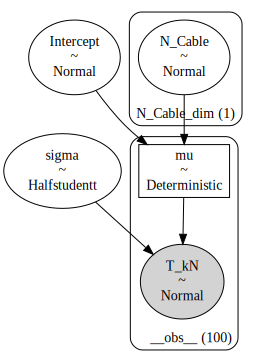

In [37]:
# creamos un modelo lineal (con error absoluto)
model_A = bmb.Model('T_kN ~ N_Cable', data=df_c_red)
model_A.build()

# visualizacion
model_A.graph()

Noten que `Bambi` me aclara cuántas dimensiones (parámetros) tiene asociadas el predictor `N_Cable`. Como yo tenía dos cables, uno de los cuales fue tomado como referencia, su dimensión es 1.

Una vez que llegué acá, ¡todo es lo mismo de antes!

#### Prioris

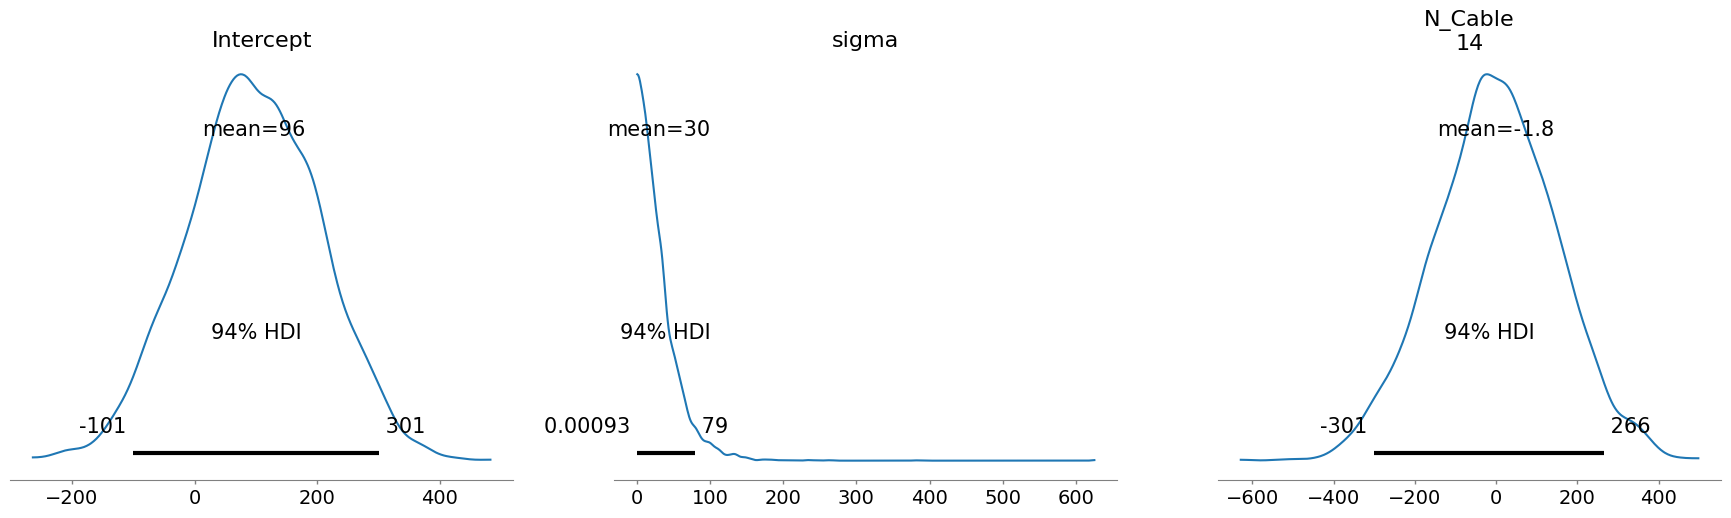

In [38]:
# ver distribuciones a priori
model_A.plot_priors()
plt.show()

#### Inferencia

Output()

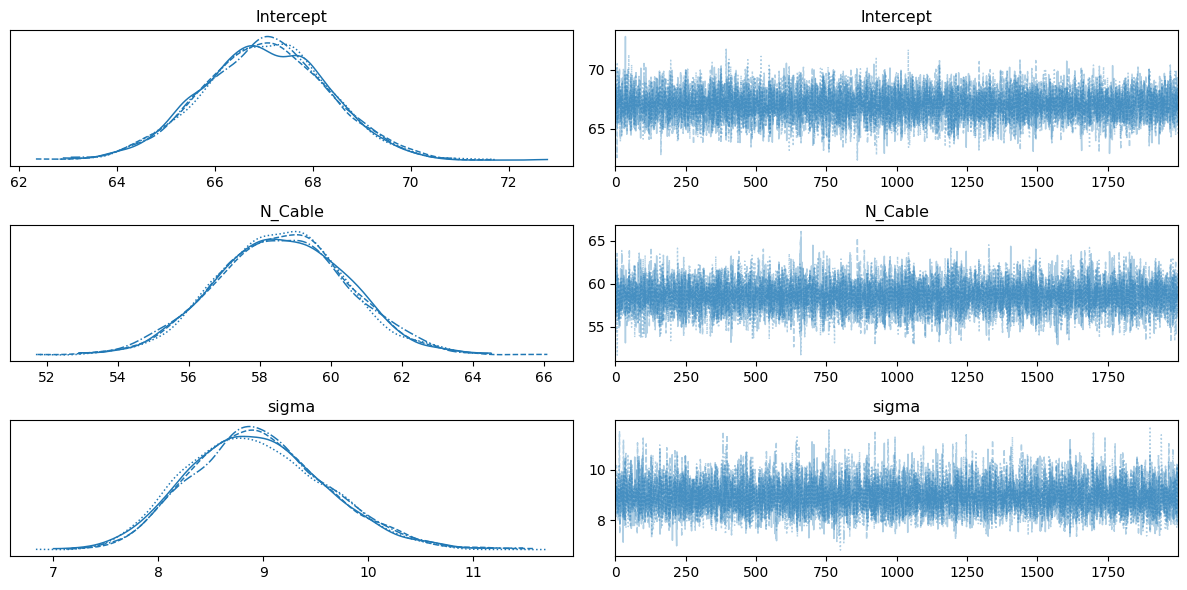

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    67.023  1.279  64.733   69.562      0.012    0.014   11981.0   
N_Cable[14]  58.601  1.823  55.022   61.866      0.016    0.022   12243.0   
sigma         8.955  0.654   7.772   10.178      0.006    0.008   11735.0   

             ess_tail  r_hat  
Intercept      6225.0    1.0  
N_Cable[14]    5471.0    1.0  
sigma          5801.0    1.0

In [39]:
# Realizar la inferencia
results_A = model_A.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_A)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_A)

#### Posterior

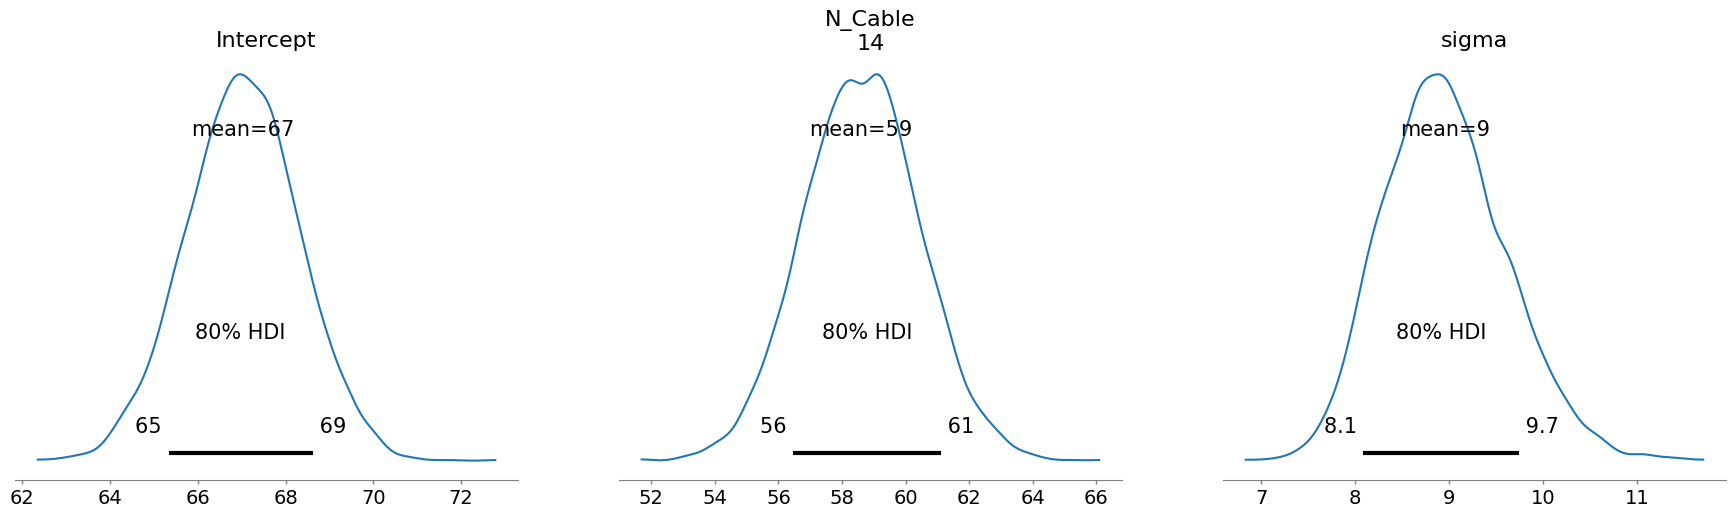

In [40]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_A,hdi_prob=0.8)
plt.show()

#### Visualización del ajuste

Yo podría sentarme a mirar qué significa exactamente cada parámetro (y debiera). Pero veamos cómo se traduce el modelo en tensiones en los cables de forma directa.

Primero, veamos si mi modelo se ajusta a los datos con `.predict()` a secas, y luego con la función `plot_ppc()`.

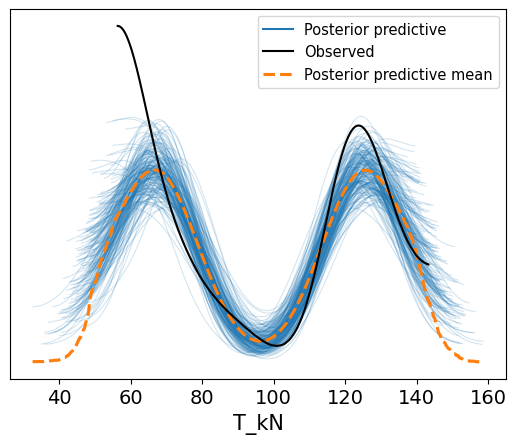

In [41]:
# Genero replicas
model_A.predict(results_A,kind='response')

# chequeo de la predictiva
az.plot_ppc(results_A,num_pp_samples=200)
plt.show()

Y, ahora, predizcamos directamente los datos como si no los hubiesemos visto. Armamos un dataset nuevo con el input (cable 10 y 14), y hacemos la predicción en un nuevo Inference Data.

In [42]:
# Genero un nuevo dataset con los cables que quiero predecir
df_c_new = pd.DataFrame({'N_Cable':[10,14]},dtype="category")

df_c_new

N_Cable
0      10
1      14

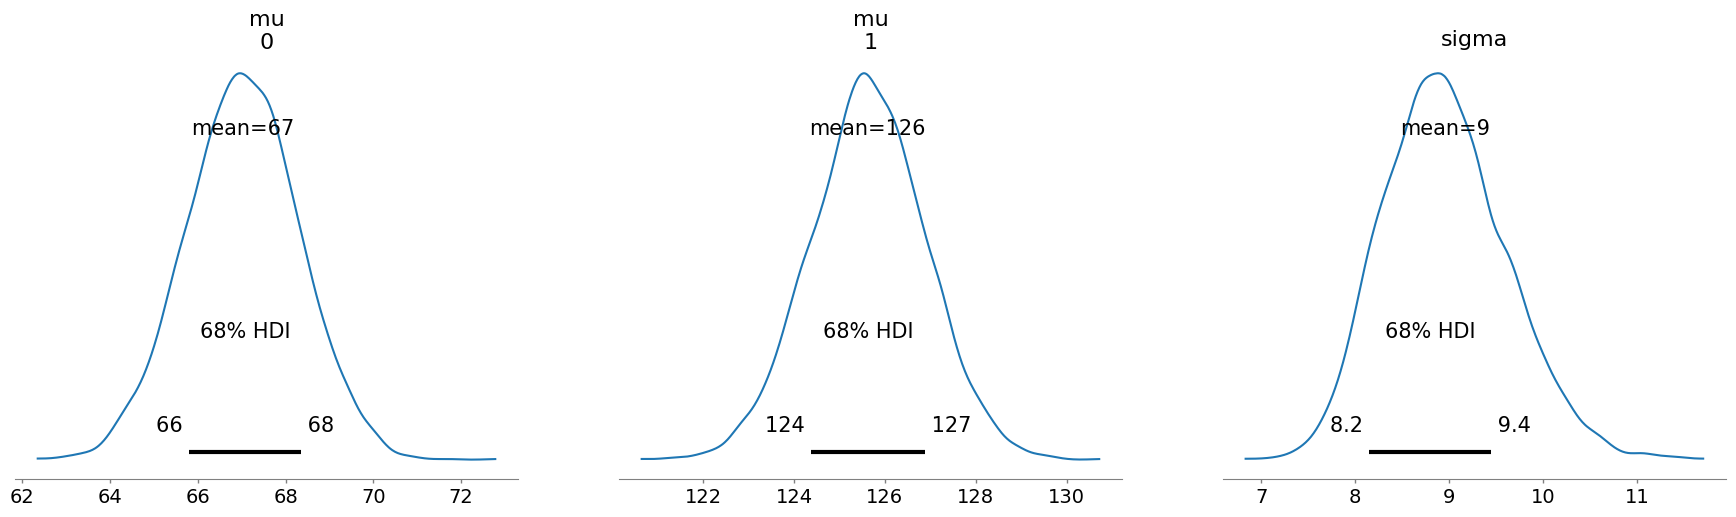

In [43]:
# Simulo sus propiedades
results_A_new = model_A.predict(results_A,data=df_c_new,inplace=False,kind='response')

# grafico posterior
az.plot_posterior(results_A_new,var_names=['mu','sigma'],hdi_prob=0.68)
plt.show()

Noten que, más allá del significado de los parámetros con los que construí el modelo, `Bambi` me devuelve directamente el valor medio de la tensión (y el desvío estandar) para cada cable por separado. Es decir, ¡hace las cuentas por mí!

También me da, si le pido, la distribución posterior predictiva de la tensión en un ensayo de cables.

**Nota**: En este ejercicio, tal vez el valor medio sea más representativo de la tensión real en el cable, siendo la dispersión producto de errores de medición.

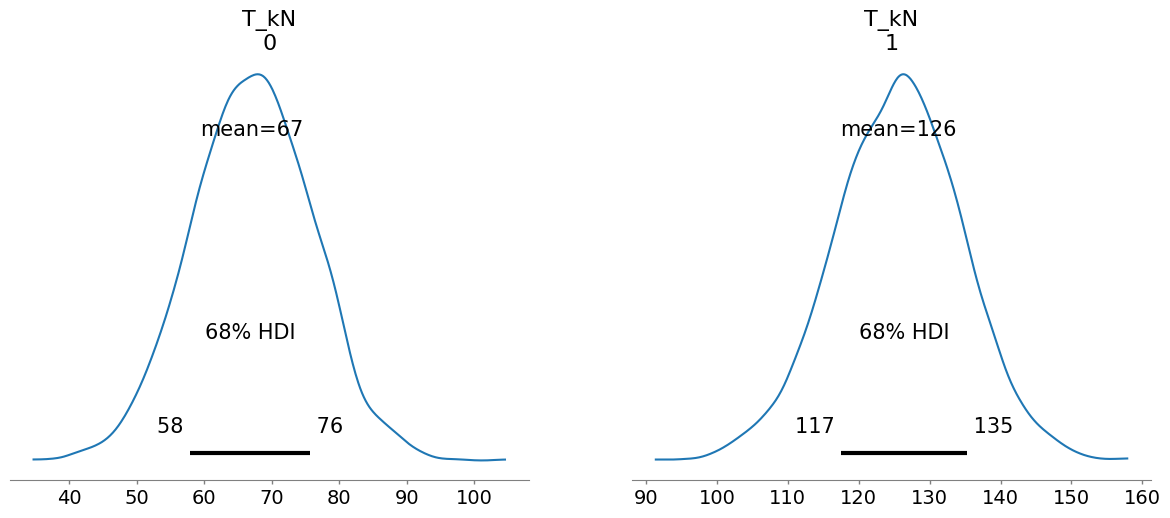

In [44]:
# grafico posterior predictiva
az.plot_posterior(results_A_new,group='posterior_predictive',hdi_prob=0.68)
plt.show()

### Modelo 2: Mi parámetro es cada valor medio

Otra forma de escribir el mismo modelo sería:

$$T =T_{i} \cdot N_{Cable} + error$$

En este modelo, $N_{Cable}$ es un índice que me dice qué valor de tensión tomar, si $T_{10}$ o $T_{14}.

Escrito en el formato que usamos habitualmente, el modelo es:

$$T \sim Normal(\mu, \sigma)$$

$$\mu = A_{i} \cdot N_{Cable}$$

$$p(A_{10}) \sim Bambi$$
$$p(A_{14}) \sim Bambi$$
$$p(\sigma) \sim Bambi$$

En `Bambi` esto se carga igual que siempre, con `N_cable` como variable explicativa. Si nosotros no queremos que `Bambi` tome una categoría de referencia, entonces tenemos que anular el "Intercept", que se logra colocando un 0 igual que en el ejercicio anterior.

ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: random_make_inplace
ERROR:pytensor.graph.rewriting.basic:node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/random/rewriting/basic.py", line 50, in random_make_inplace
    new_outputs = new_op.make_node(*node.inputs).outputs
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^

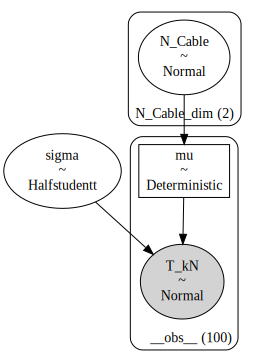

In [45]:
# creamos un modelo lineal (con error absoluto)
model_B = bmb.Model('T_kN ~ 0 + N_Cable', data=df_c_red)
model_B.build()

# visualizacion
model_B.graph()

Noten que `Bambi` me aclara cuántas dimensiones (parámetros) tiene asociadas el predictor `N_Cable`. Como yo tenía dos cables y no hay cable de referencia, su dimensión es 2 (una tensión por cada cable).

Una vez que llegué acá, ¡todo es lo mismo de antes!

#### Prioris

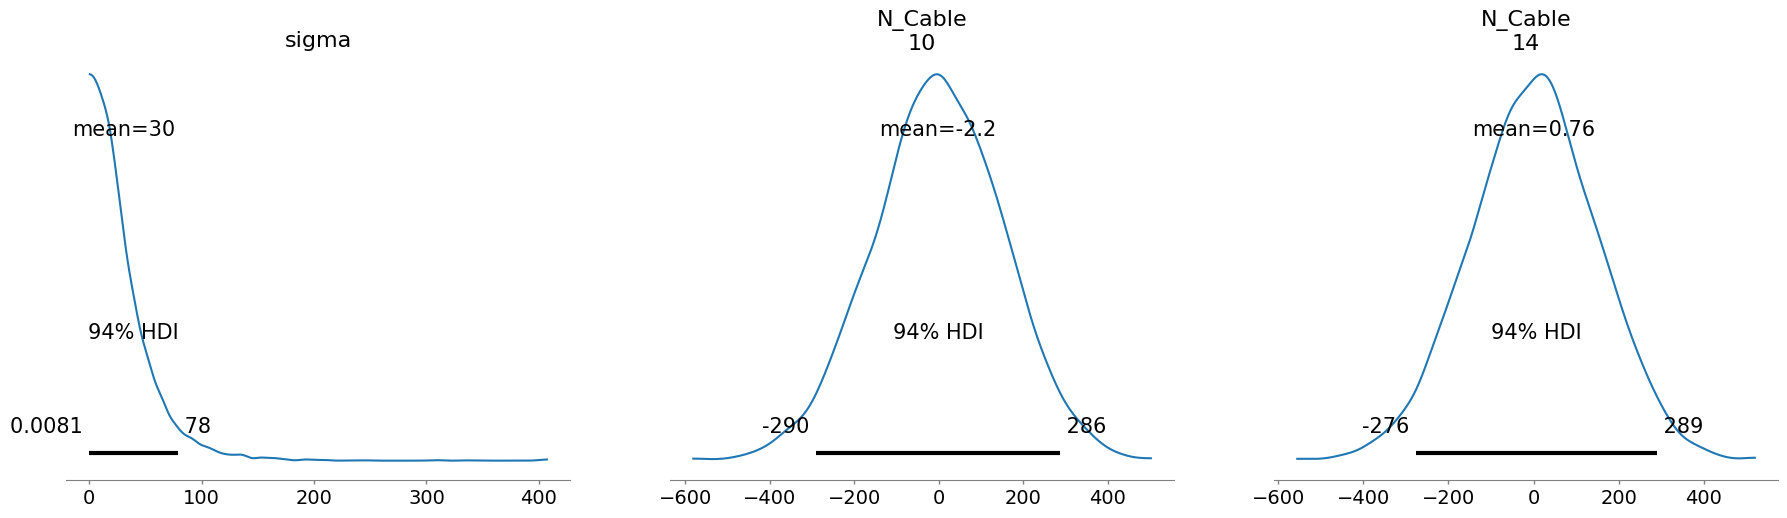

In [46]:
# ver distribuciones a priori
model_B.plot_priors()
plt.show()

#### Inferencia

Output()

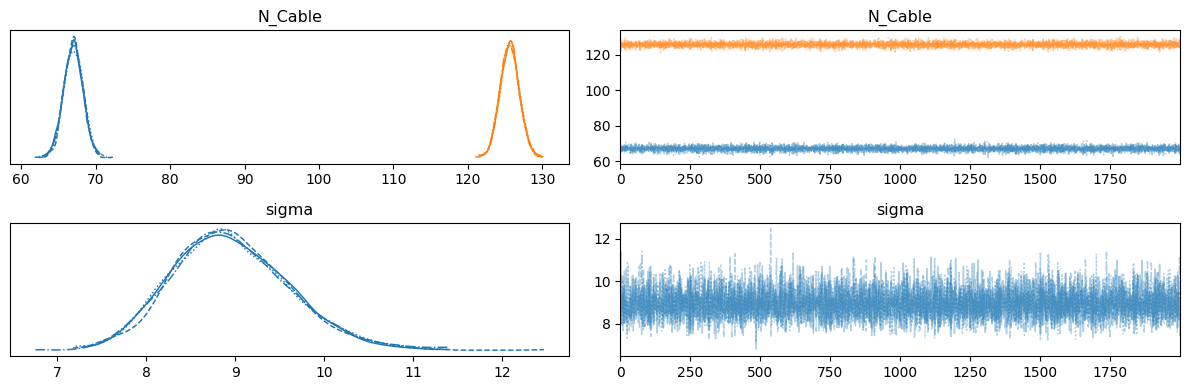

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
N_Cable[10]   66.990  1.281   64.491   69.300      0.012    0.015   11047.0   
N_Cable[14]  125.623  1.279  123.227  128.004      0.012    0.014   12130.0   
sigma          8.951  0.658    7.745   10.189      0.007    0.007   10451.0   

             ess_tail  r_hat  
N_Cable[10]    6129.0    1.0  
N_Cable[14]    6056.0    1.0  
sigma          6478.0    1.0

In [47]:
# Realizar la inferencia
results_B = model_B.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_B)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_B)

#### Posterior

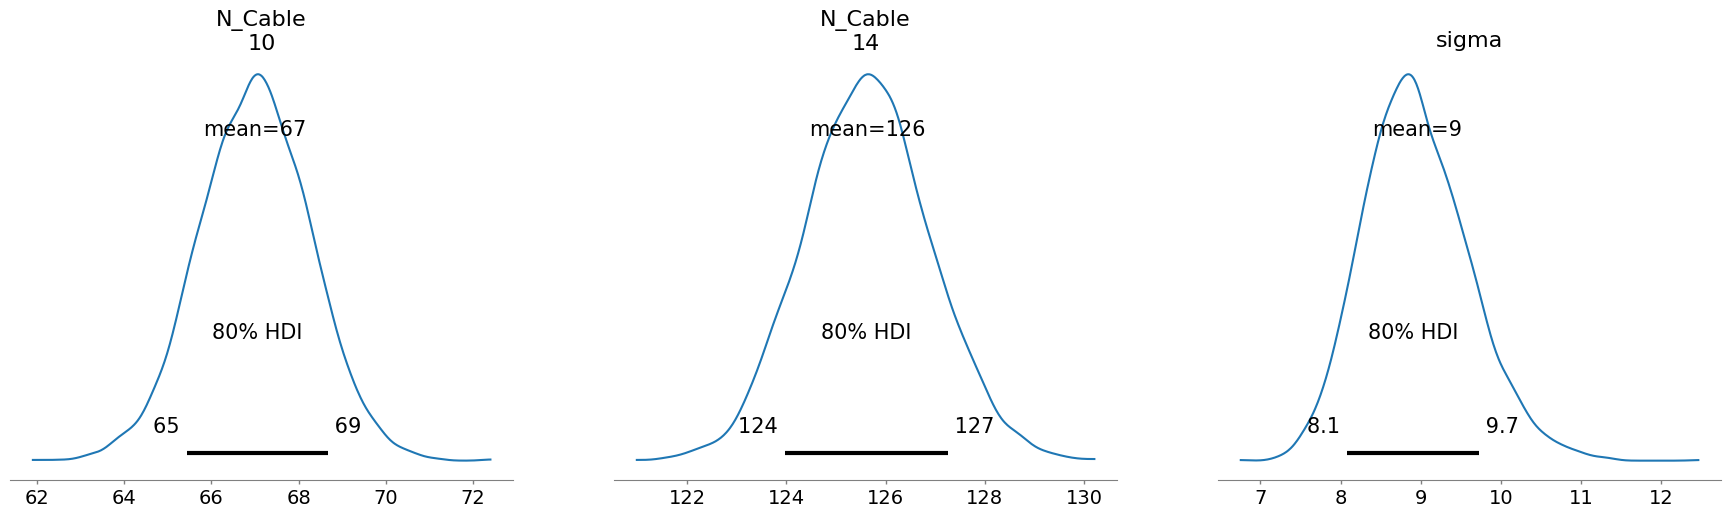

In [48]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_B,hdi_prob=0.8)
plt.show()

#### Visualización del ajuste

Fijensé que lo que sigue aquí no depende de la parametrización, y ¡me da exactamente igual!

Eso es porque los modelos eran equivalentes, con un cambio nada maás de significado de los parámetros. Pero predicen lo mismo, y este formato para analizarlo me permite llegar a ese resultado final sin pensar mucho en cómo lo construí.

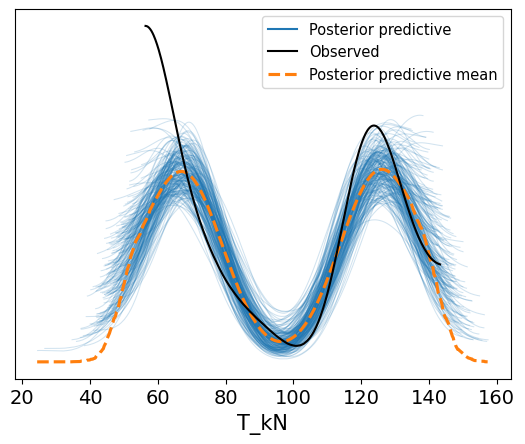

In [49]:
# Genero replicas
model_B.predict(results_B,kind='response')

# chequeo de la predictiva
az.plot_ppc(results_B,num_pp_samples=200)
plt.show()

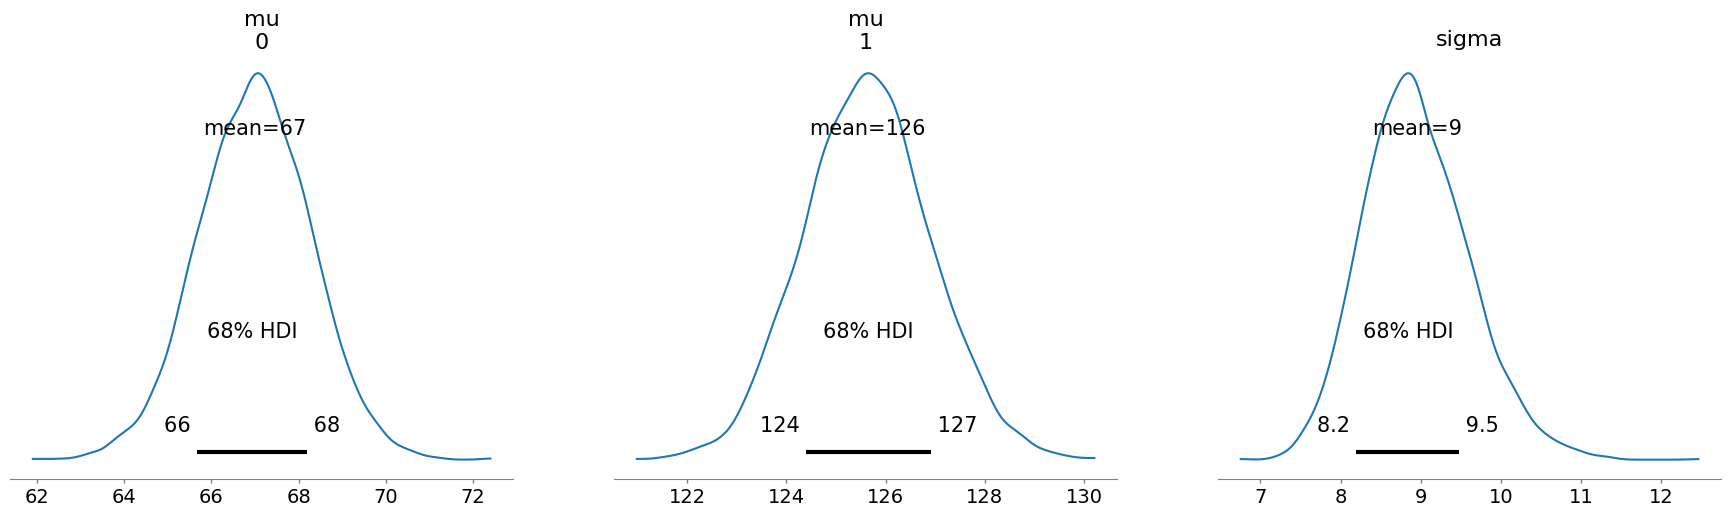

In [50]:
# Simulo sus propiedades
results_B_new = model_B.predict(results_B,data=df_c_new,inplace=False,kind='response')

# grafico posterior
az.plot_posterior(results_B_new,var_names=['mu','sigma'],hdi_prob=0.68)
plt.show()

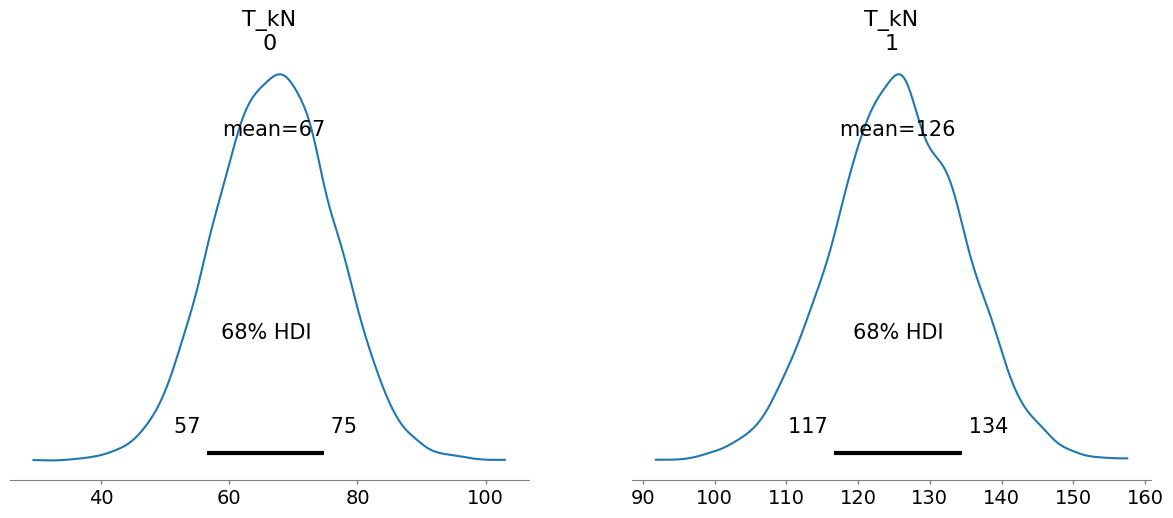

In [51]:
# grafico posterior predictiva
az.plot_posterior(results_B_new,group='posterior_predictive',hdi_prob=0.68)
plt.show()

### Modelo 3: Dispersión diferente para cada cable

Por último, así como el valor medio puede depender del número de cable, también lo puede hacer el desvío estandar (¿por qué no?). Esto se conoce como un modelo distribucional.

La forma de plantearlo es exactamente igual. En `Bambi`, tendré que utilizar la función `Formula()` para escribir dos ecuaciones: La ecuación para el valor medio igual que antes, y también la ecuación para el desvío estandar.

**Nota**: Cuidado, el link por default para el desvío estandar es el logaritmo.

Dicho esto, todo sigue igual que antes. La única diferencia es que ahora tengo 4 parámetros. 2 tensiones y 2 dispersiones. Y eso aparecerá luego al predecir también.

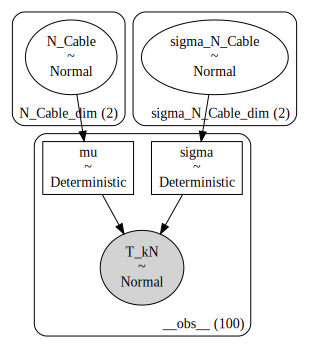

In [52]:
# creamos un modelo lineal (con error absoluto)
model_C = bmb.Model(bmb.Formula('T_kN ~ 0 + N_Cable','sigma ~ 0 + N_Cable'), data=df_c_red)
model_C.build()

# visualizacion
model_C.graph()

#### Prioris

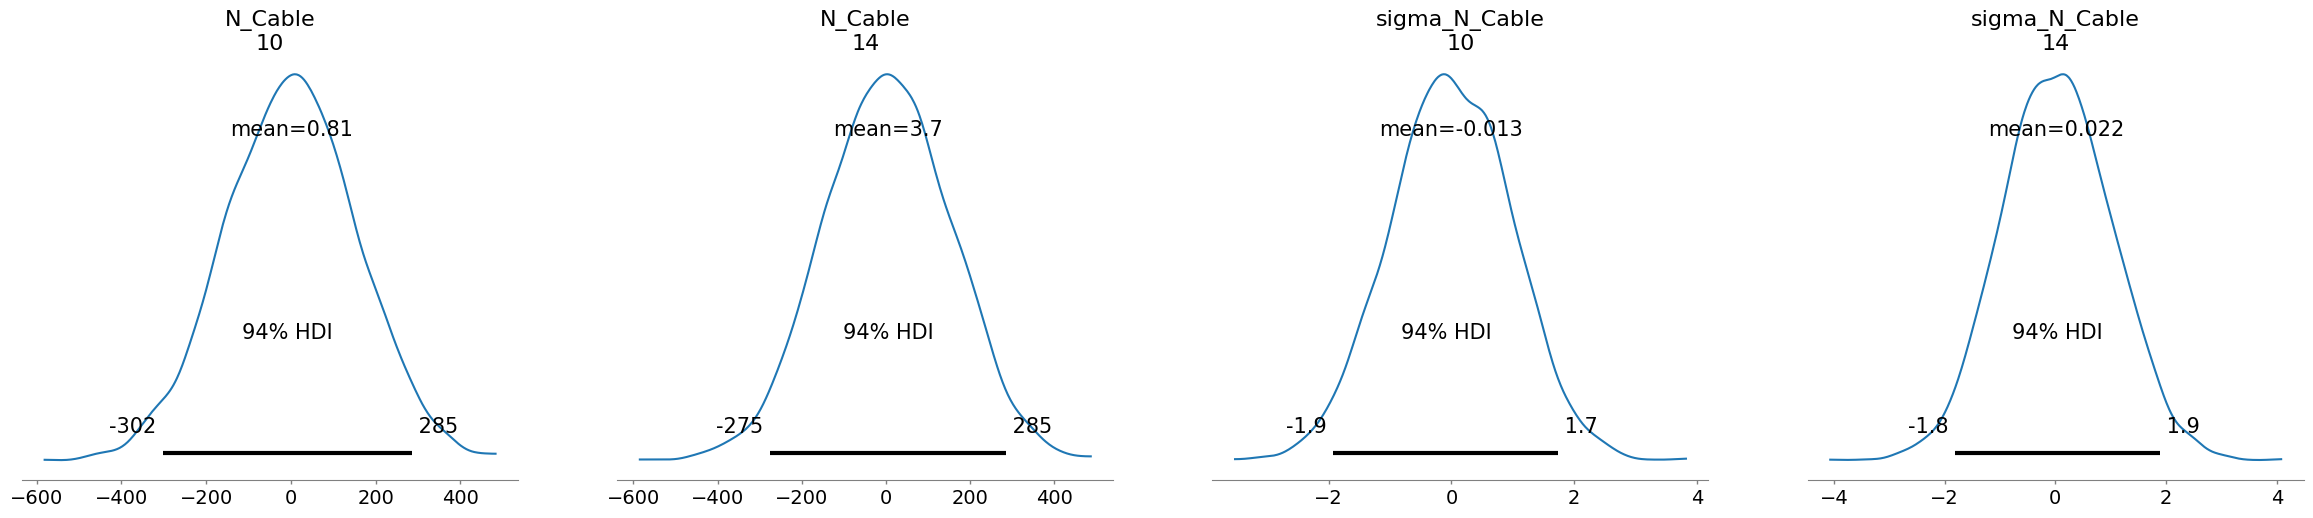

In [53]:
# ver distribuciones a priori
model_C.plot_priors()
plt.show()

#### Inferencia

Output()

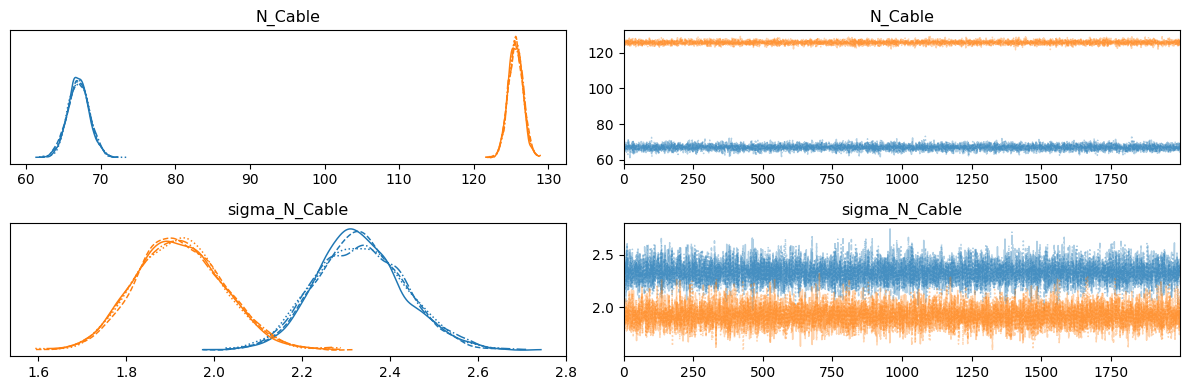

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
N_Cable[10]         67.030  1.476   64.373   69.958      0.014    0.016   
N_Cable[14]        125.619  0.982  123.711  127.403      0.009    0.011   
sigma_N_Cable[10]    2.332  0.101    2.150    2.528      0.001    0.001   
sigma_N_Cable[14]    1.922  0.100    1.749    2.116      0.001    0.001   

                   ess_bulk  ess_tail  r_hat  
N_Cable[10]         10875.0    6664.0    1.0  
N_Cable[14]         11326.0    6213.0    1.0  
sigma_N_Cable[10]   13068.0    6520.0    1.0  
sigma_N_Cable[14]   11004.0    6422.0    1.0

In [54]:
# Realizar la inferencia
results_C = model_C.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_C)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_C)

#### Posterior

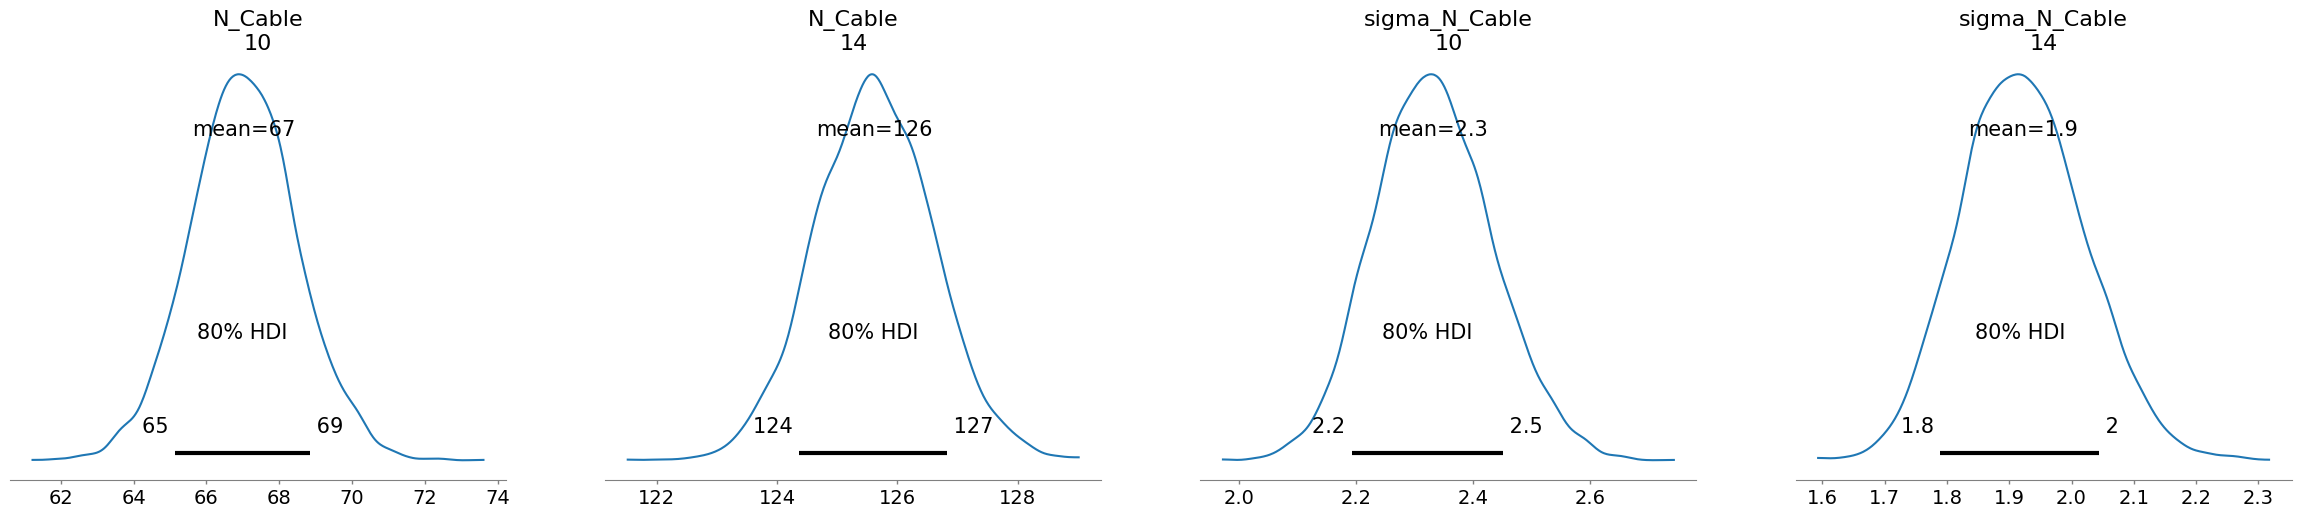

In [55]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_C,hdi_prob=0.8)
plt.show()

#### Visualización del ajuste

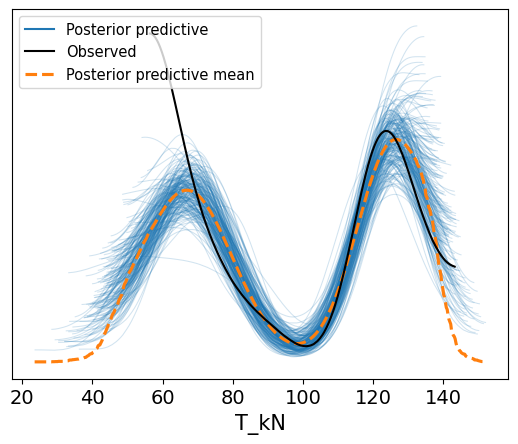

In [56]:
# Genero replicas
model_C.predict(results_C,kind='response')

# chequeo de la predictiva
az.plot_ppc(results_C,num_pp_samples=200)
plt.show()

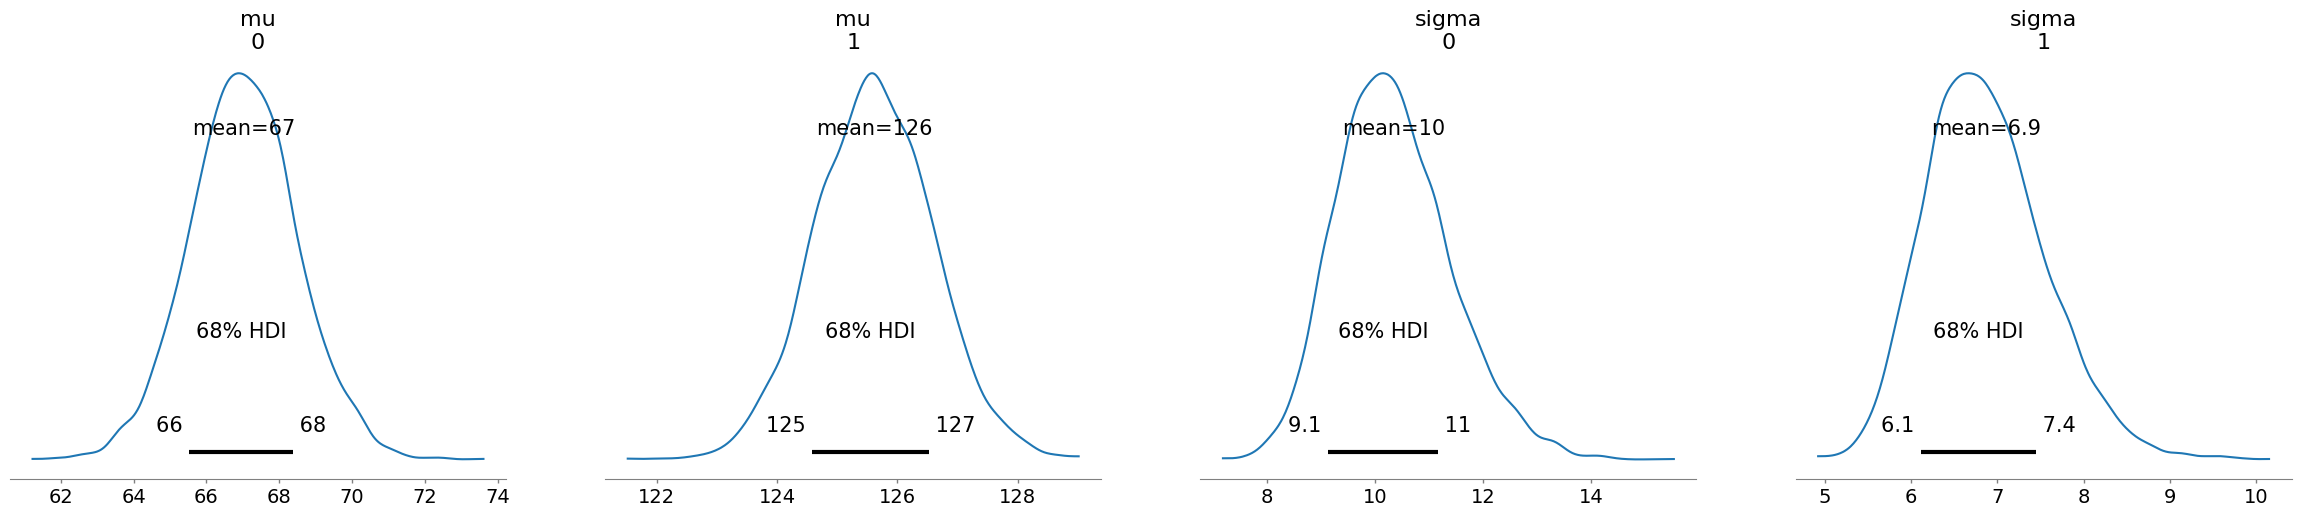

In [57]:
# Simulo sus propiedades
results_C_new = model_C.predict(results_C,data=df_c_new,inplace=False,kind='response')

# grafico posterior
az.plot_posterior(results_C_new,var_names=['mu','sigma'],hdi_prob=0.68)
plt.show()

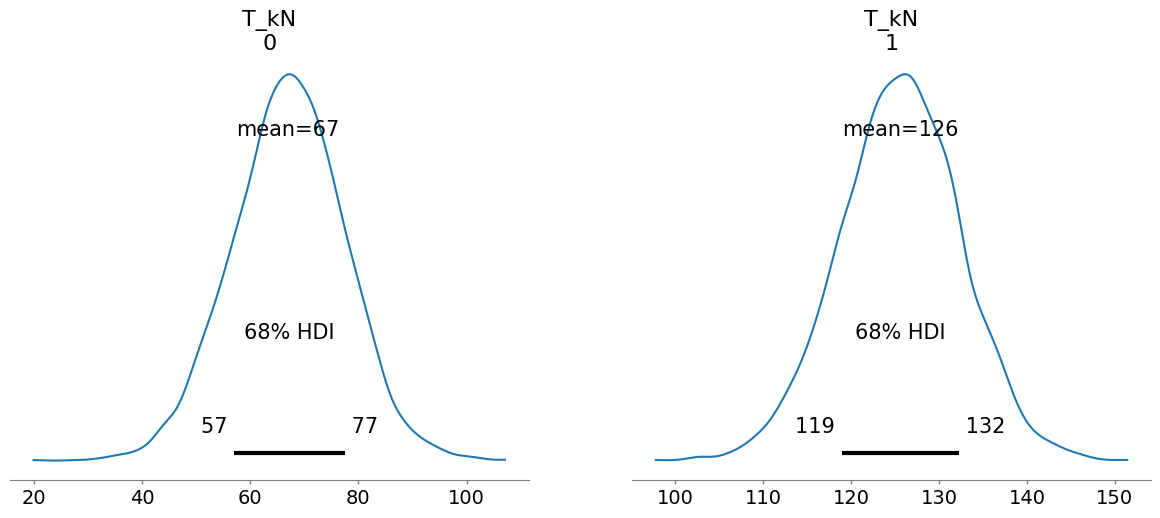

In [58]:
# grafico posterior predictiva
az.plot_posterior(results_C_new,group='posterior_predictive',hdi_prob=0.68)
plt.show()